In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response, load_behavior_txt
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y']

mouse_id = 0
thresh = 0.05 # correlation threshold for selecting important axons
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
        
# cmap = plt.cm.get_cmap('viridis_r')
if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    im_proportion = 0.3
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    im_proportion = 0.2
    
day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
                 [[1,2,4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
                 [[1,2], [5], [11]], # 15
                 [[1,2,3,4,5], [6,9,10], [11,15]]]

In [15]:
day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
                 [[1,2,4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
                 [[1,2], [5], [11]], # 15
                 [[1,2,3,4,5], [6,9,10], [11,15]]]

In [7]:
from scipy.interpolate import interp1d
def smooth_line(inputx, inputy):
    xx = np.linspace(inputx.min(),inputx.max(), 1000)
    itp = interp1d(inputx,inputy, kind='linear')
    window_size, poly_order = 301, 2
    yy = savgol_filter(itp(xx), window_size, poly_order) # smooth
    return xx, yy

# helper function

In [4]:
def remove_false(inputx, inputy):
    inputy = np.array(inputy)
    inputx = np.array(inputx)
    valid_ind = np.where(inputy > 0)[0]
    return inputx[valid_ind], inputy[valid_ind]

def important_axons(stim_w, proportion=0.1):
    # thresh = 0.001
    # axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    # axons_contribution_prelick = np.mean(prelick_weights[:, :45], axis=1)
    # idx = np.where(axons_contribution > thresh)[0]
    # non_idx = np.where(axons_contribution <= thresh)[0]
    NA = stim_weights.shape[0]
    axons_contribution = np.mean(stim_weights[:, 45:], axis=1)
    axons_contribution_threshold = np.mean(axons_contribution) + np.std(axons_contribution)
    w_sort = np.argsort(axons_contribution)
    NNA = int(proportion*NA)
    idx = w_sort[-NNA:]
    non_idx = w_sort[:(NA-NNA)]
#     idx = np.where(axons_contribution > axons_contribution_threshold)
#     non_idx = np.where(axons_contribution <= axons_contribution_threshold)
    return idx, non_idx

def classifier(x, y, ratio=2/3):
    '''
    ratio: train:test
    '''
    accs = []
    weights = []
    # make sure each class has same number of samples
    ind1 = np.where(y==0)[0]
    ind2 = np.where(y==1)[0]
    valid_amount = min(len(ind2), len(ind1))
    if valid_amount < 10:
        print('no avalible binary labels for classifier')
        return False, False
    valid_ind1 = ind1[np.random.choice(np.arange(len(ind1)), valid_amount, replace=False)]
    valid_ind2 = ind2[np.random.choice(np.arange(len(ind2)), valid_amount, replace=False)]
    valid_ind = np.hstack([valid_ind1, valid_ind2])
    print('valid samples: {}'.format(len(valid_ind)))
    x = x[valid_ind]
    y = y[valid_ind]
    N = len(x) # number of samples
    F = x.shape[1] # number of features
    for seed in range(10):
        random.seed(seed)
        np.random.seed(seed)
        itrain = np.random.choice(np.arange(N), size=int(N*ratio), replace=False)
        itest = np.setxor1d(np.arange(N), itrain)
        ylabel = y[itrain]
        new_seed = 1000
        while (np.sum(ylabel[0] == ylabel) == len(ylabel)):
            new_seed +=1
            random.seed(seed+new_seed)
            np.random.seed(seed+new_seed)
            itrain = np.random.choice(np.arange(N), size=int(N*ratio), replace=False)
            itest = np.setxor1d(np.arange(N), itrain)
            ylabel = y[itrain]
            if new_seed >= 1050:
                print('no avalible binary labels for classifier')
                return False, False

        model = LogisticRegression(solver='liblinear', random_state=seed)
        model.fit(x[itrain], y[itrain])
        te_pred = model.predict(x[itest])
        acc = np.sum(te_pred == y[itest]) / len(itest)
        cur_weights = model.coef_
        accs.append(acc)
        weights.append(cur_weights)
    avg_acc = np.mean(accs)
    weights = np.mean(np.array(weights), axis=0)
    return avg_acc, weights

def behavior_performance(mouse_name, drive):
    beh_data_path = "{}:/Jenni/{}/behavior/justbehavior".format(drive, mouse_name)
    fnames = [_ for _ in os.listdir(beh_data_path) if _.endswith('txt')]

    from tkinter import Tcl
    fnames = Tcl().call('lsort', '-dict', fnames)
    nBlocks = len(fnames)
    pbRes = np.zeros((4, nBlocks))
    rlRes = np.zeros((4, nBlocks))
    nPB = np.zeros(nBlocks)
    days = np.zeros(nBlocks)
    for i in range(nBlocks):
        tmp = fnames[i].split('_')[-1]
        days[i] = int(tmp.split('v')[0])
        fpath = os.path.join(beh_data_path, fnames[i])
        bmat = load_behavior_txt(fpath)
        behavior = bmat[:, 12].reshape(-1).astype(int)
        outcome = bmat[:, 3].reshape(-1).astype(int)
        nPB[i] = np.sum(behavior==0)
        if nPB[i] > 0:
            pbIdx = np.where(behavior==0)
            pbOutcome = outcome[pbIdx]
            for j in range(4):
                pbRes[j, i] = np.sum(pbOutcome == j+1) / nPB[i]

        rlIdx = np.where(behavior==1)
        rlOutcome = outcome[rlIdx]
        for j in range(4):
            rlRes[j, i] = np.sum(rlOutcome == j+1) / (100 - nPB[i])
    days = days.astype('int')
    x = np.arange(nBlocks)
    ptrue = pbRes[0] + pbRes[3]
    rtrue = rlRes[0] + rlRes[3]
    return ptrue, rtrue, fnames

# block 1

In [348]:
day = 2
pre_window = 45
post_window = 45
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

iblock = 1
block = data[0, iblock-1]
# normalize doesn't have much effect on the result, so set it to False
cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)
NT, NA, NF = stim_resp.shape # #trials #axonns #frames

performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

stim = np.ones(cues.shape)
stim[np.where(cues==2)] = 0 
stim[np.where(cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

spks = stim_resp.reshape(stim_resp.shape[0], -1)
acc, weights = classifier(spks, stim)
stim_weights = weights.reshape((NA, NF))
daily_stim_accs.append(acc)
print('accuracy predicting stimulus identity on test set: ', acc)

prelick = (np.sum(alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
prelick = np.multiply((prelick == 1), 1)
acc, weights = classifier(spks, prelick)
prelick_weights = weights.reshape((NA, NF))
print('accuracy predicting prelick on test set: ', acc)

-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[block 1, behavior performance 47.00%]
accuracy predicting stimulus identity on test set:  0.7176470588235295
accuracy predicting prelick on test set:  0.6823529411764706


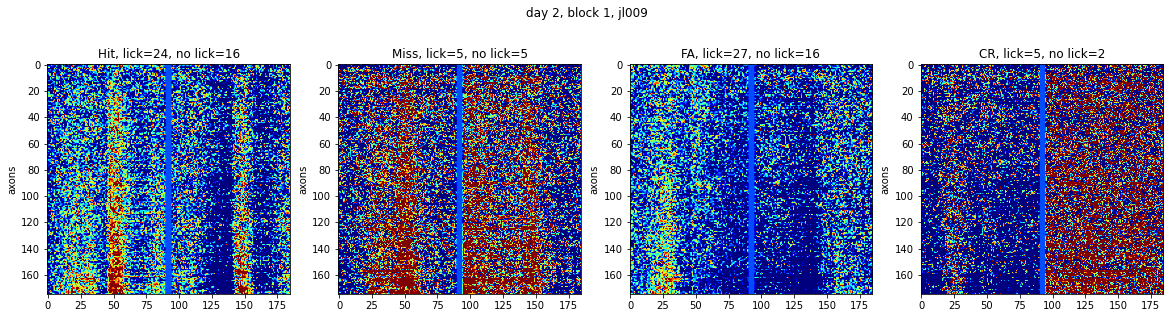

In [333]:
if iblock == 1:
    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))
sorted_stim_resp = stim_resp[:, isort, :]
plt.figure(figsize=(20,5))
for outcome_index in range(1,5):
    all_resp = np.zeros((NA, (pre_window+post_window)*2+5))
    ioutcome = np.where(outcomes == outcome_index)[0]
    oresp = sorted_stim_resp[ioutcome]

    lick = alllicks[ioutcome] 
    n_prelicks = np.sum(lick[:, (pre_window-30):(pre_window-15)], axis=1)
    lick_idx = np.where(n_prelicks != 0)[0] # with prelick
    resp = oresp[lick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)

    # isort = np.argsort(resp[:, 30:].sum(axis=1)) # sort by pre lick frequency
    all_resp[:, :(pre_window+post_window)] = resp

    nolick_idx = np.where(n_prelicks == 0)[0] # without prelick
    resp = oresp[nolick_idx]
    resp = resp.mean(axis=0) # average response of each axon in one day for a outcome. -> (NN, 75)
    all_resp[:, ((pre_window+post_window)+5):] = resp

    plt.subplot(1,4,outcome_index)
    plt.imshow(all_resp, cmap='jet', vmin=-0.1, vmax=0.4)
    plt.ylabel('axons')
    # plt.colorbar()
    # plt.plot(x, all_resp, label='all', color='black', linestyle='--')
    plt.title('{}, lick={}, no lick={}'.format(outcome_list[outcome_index-1], len(lick_idx), len(nolick_idx)))
plt.suptitle('day {}, block {}, {}'.format(day, iblock, mouse_name))
plt.show()

# difference in response

In [431]:
day = 1
pre_window = 45
post_window = 45
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

iblocks = daily_blocks(data, day)
iblock = iblocks[0]
block = data[0, iblocks[0]]
# normalize doesn't have much effect on the result, so set it to False
cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

# preserve_trials = np.arange(100)
# preserve_trials = preserve_trials[:30]
# cues = cues[preserve_trials]
# outcome = outcomes[preserve_trials]
# stim_resp = stim_resp[preserve_trials]
# alllick = alllicks[preserve_trials]

NT, NA, NF = stim_resp.shape # #trials #axonns #frames

performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

stim = np.ones(cues.shape)
stim[np.where(cues==2)] = 0 
stim[np.where(cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

spks = stim_resp.reshape(stim_resp.shape[0], -1)
acc, weights = classifier(spks, stim)
stim_weights = weights.reshape((NA, NF))
print('accuracy predicting stimulus identity on test set: ', acc)

isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

im_axon_ind_block1 = isort[-int(NA*0.1):] # top 10%

iblock = iblocks[-1]
block = data[0, iblocks[-1]]
# normalize doesn't have much effect on the result, so set it to False
cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

# preserve_trials = np.arange(100)
# preserve_trials = preserve_trials[70:]
# cues = cues[preserve_trials]
# outcome = outcomes[preserve_trials]
# stim_resp = stim_resp[preserve_trials]
# alllick = alllicks[preserve_trials]

NT, NA, NF = stim_resp.shape # #trials #axonns #frames

performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

stim = np.ones(cues.shape)
stim[np.where(cues==2)] = 0 
stim[np.where(cues==4)] = 0
stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

spks = stim_resp.reshape(stim_resp.shape[0], -1)
acc, weights = classifier(spks, stim)
stim_weights = weights.reshape((NA, NF))
print('accuracy predicting stimulus identity on test set: ', acc)

isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

im_axon_ind_block3 = isort[-int(NA*0.1):] # top 10%

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 47.00%]
accuracy predicting stimulus identity on test set:  0.7176470588235295
[block 2, behavior performance 53.00%]
accuracy predicting stimulus identity on test set:  0.6058823529411764


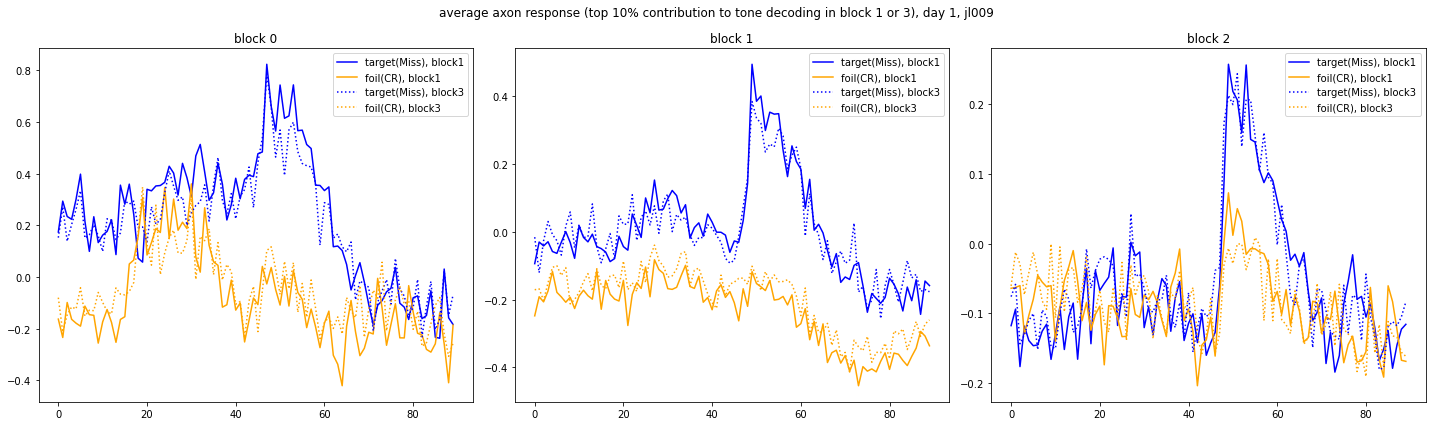

In [403]:
plt.figure(figsize=(20, 6))
for i, iblock in enumerate(iblocks):
    plt.subplot(1,3,i+1)
    block = data[0, iblock]
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    im_resp = stim_resp[:, im_axon_ind_block1, :]
    target_ind = np.where(outcomes==2)[0]
    foil_ind = np.where(outcomes==4)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0), label='target(Miss), block1', c='blue')
    plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(CR), block1', c='orange')
    
    im_resp = stim_resp[:, im_axon_ind_block3, :]
    target_ind = np.where(outcomes==2)[0]
    foil_ind = np.where(outcomes==4)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0), label='target(Miss), block3', c='blue', linestyle=':')
    plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(CR), block3', c='orange', linestyle=':')
    plt.legend()
    plt.title('block {}'.format(i))
plt.suptitle('average axon response (top 10% contribution to tone decoding in block 1 or 3), day {}, {}'.format(day, mouse_name))
plt.tight_layout()

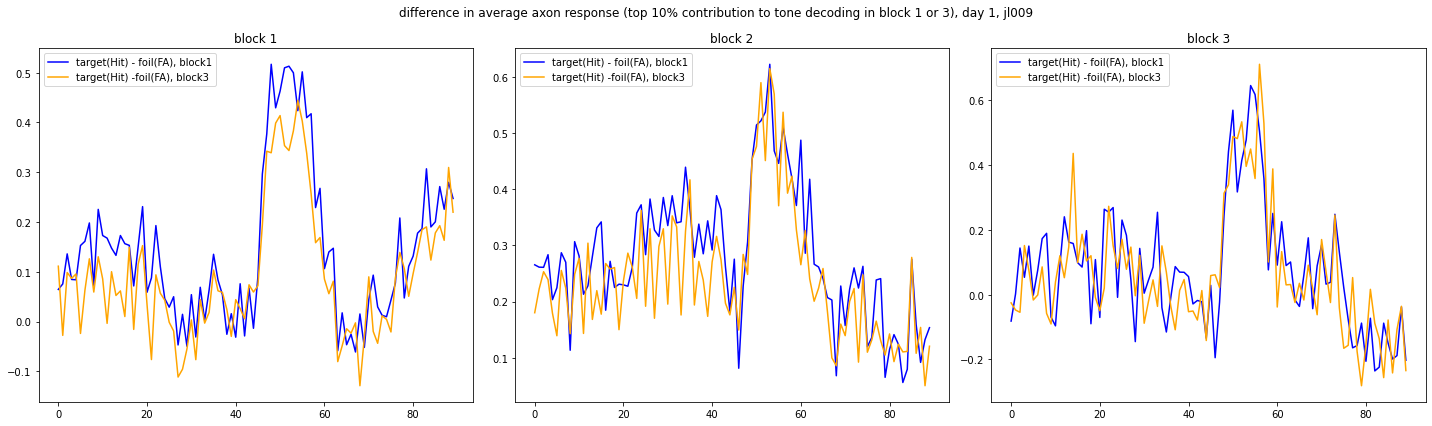

In [404]:
plt.figure(figsize=(20, 6))
for i in [1,2,3]:
    plt.subplot(1,3,i)
    block = data[0, i-1]
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    im_resp = stim_resp[:, im_axon_ind_block1, :]
    target_ind = np.where(outcomes==1)[0]
    foil_ind = np.where(outcomes==3)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0), label='target(Hit) - foil(FA), block1', c='blue')
    # plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(FA), block1', c='orange')
    
    im_resp = stim_resp[:, im_axon_ind_block3, :]
    target_ind = np.where(outcomes==1)[0]
    foil_ind = np.where(outcomes==3)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0), label='target(Hit) -foil(FA), block3', c='orange')
    # plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(FA), block3', c='red')
    plt.legend()
    plt.title('block {}'.format(i))
plt.suptitle('difference in average axon response (top 10% contribution to tone decoding in block 1 or 3), day {}, {}'.format(day, mouse_name))
plt.tight_layout()

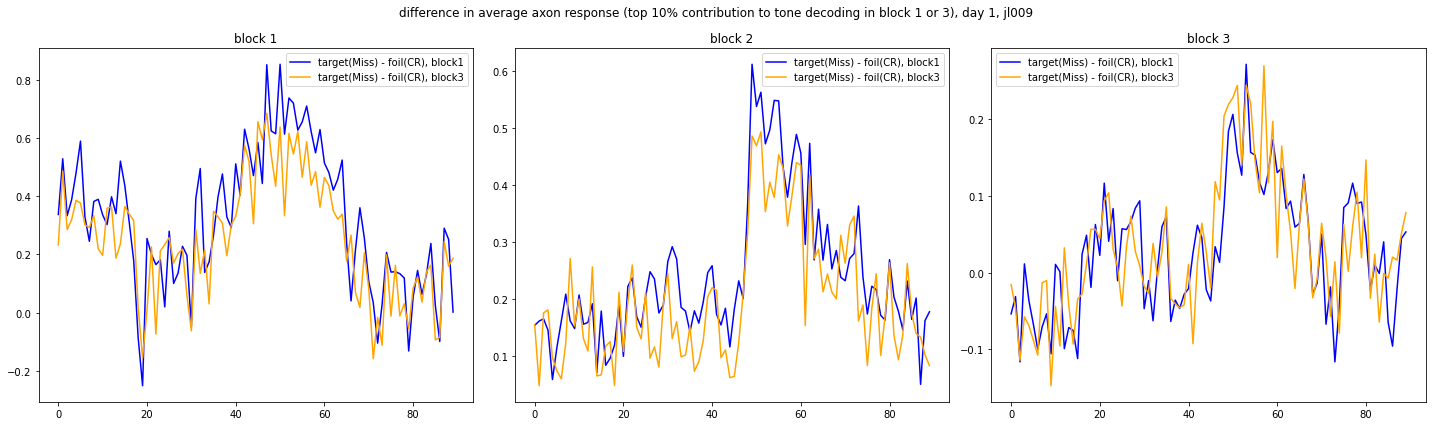

In [405]:
plt.figure(figsize=(20, 6))
for i in [1,2,3]:
    plt.subplot(1,3,i)
    block = data[0, i-1]
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    im_resp = stim_resp[:, im_axon_ind_block1, :]
    target_ind = np.where(outcomes==2)[0]
    foil_ind = np.where(outcomes==4)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0), label='target(Miss) - foil(CR), block1', c='blue')
    # plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(FA), block1', c='orange')
    
    im_resp = stim_resp[:, im_axon_ind_block3, :]
    target_ind = np.where(outcomes==2)[0]
    foil_ind = np.where(outcomes==4)[0]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    plt.plot(np.arange(90), np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0), label='target(Miss) - foil(CR), block3', c='orange')
    # plt.plot(np.arange(90), np.mean(im_foil_spks_avg, axis=0), label='foil(FA), block3', c='red')
    plt.legend()
    plt.title('block {}'.format(i))
plt.suptitle('difference in average axon response (top 10% contribution to tone decoding in block 1 or 3), day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [438]:
avg_diff = np.zeros((len(iblocks), 2)) # sorted block, block, lick or not
for i, iblock in enumerate(iblocks):
    block = data[0, iblock]
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    target_ind = np.where(outcomes==2)[0]
    foil_ind = np.where(outcomes==4)[0]
    im_resp = stim_resp[:, im_axon_ind_block1, :]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
    block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))
    
    im_resp = stim_resp[:, im_axon_ind_block3, :]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
    block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))
    diff = block3_diff - block1_diff
    avg_diff[i, 1] = np.mean(diff[45:60])

    target_ind = np.where(outcomes==1)[0]
    foil_ind = np.where(outcomes==3)[0]
    im_resp = stim_resp[:, im_axon_ind_block1, :]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
    block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 

    im_resp = stim_resp[:, im_axon_ind_block3, :]
    im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
    im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
    # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
    block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 
    diff = block3_diff - block1_diff
    avg_diff[i, 0] = np.mean(diff[45:60])

Text(0.5, 1.0, 'difference in axon selectivity block1 - block3 \n (top contribute axons), day 1, jl009')

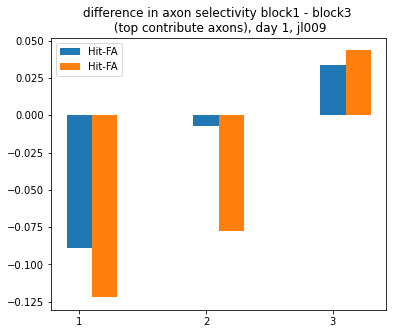

In [440]:
plt.figure(figsize=(6,5))
x = np.arange(1,4)
plt.bar(x, avg_diff[:, 0], 0.2, label='Hit-FA')
plt.bar(x+0.2, avg_diff[:, 1], 0.2, label='Hit-FA')
plt.legend()
plt.xticks(x)
plt.title('difference in axon selectivity block1 - block3 \n (top contribute axons), day {}, {}'.format(day, mouse_name))

## all

In [531]:
day = 1
pre_window = 45
post_window = 45
overlaps = []
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

    iblocks = daily_blocks(data, day)
    iblock = iblocks[0]
    block = data[0, iblocks[0]]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    NT, NA, NF = stim_resp.shape # #trials #axonns #frames

    performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
    print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

    stim = np.ones(cues.shape)
    stim[np.where(cues==2)] = 0 
    stim[np.where(cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = stim_resp.reshape(stim_resp.shape[0], -1)
    acc, weights = classifier(spks, stim)
    stim_weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)

    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

    im_axon_ind_block1 = isort[-int(NA*0.1):] # top 10%

    iblock = iblocks[-1]
    block = data[0, iblocks[-1]]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    NT, NA, NF = stim_resp.shape # #trials #axonns #frames

    performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
    print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

    stim = np.ones(cues.shape)
    stim[np.where(cues==2)] = 0 
    stim[np.where(cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = stim_resp.reshape(stim_resp.shape[0], -1)
    acc, weights = classifier(spks, stim)
    stim_weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)

    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

    im_axon_ind_block3 = isort[-int(NA*0.1):] # top 10%
    
    

    avg_diff = np.zeros((len(iblocks), 2)) # sorted block, block, lick or not
    for i, iblock in enumerate(iblocks):
        block = data[0, iblock]
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

        target_ind = np.where(outcomes==2)[0]
        foil_ind = np.where(outcomes==4)[0]
        im_resp = stim_resp[:, im_axon_ind_block1, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))

        im_resp = stim_resp[:, im_axon_ind_block3, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))
        diff = block3_diff - block1_diff
        avg_diff[i, 1] = np.mean(diff[45:60])

        target_ind = np.where(outcomes==1)[0]
        foil_ind = np.where(outcomes==3)[0]
        im_resp = stim_resp[:, im_axon_ind_block1, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 

        im_resp = stim_resp[:, im_axon_ind_block3, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 
        diff = block3_diff - block1_diff
        avg_diff[i, 0] = np.mean(diff[45:60])
    overlap_axons = len(np.intersect1d( im_axon_ind_block3,  im_axon_ind_block1)) / len(im_axon_ind_block1)
    overlaps.append(overlap_axons)
    plt.figure(figsize=(6,5))
    x = np.arange(1,len(iblocks)+1)
    plt.bar(x, avg_diff[:, 0], 0.2, label='Hit-FA')
    plt.bar(x+0.2, avg_diff[:, 1], 0.2, label='Miss-CR')
    plt.legend()
    plt.xticks(x)
    plt.title('difference in axon selectivity block1 - block3 \n (top contribute axons), day {}, {}, overlap={:.2f}%'.format(day, mouse_name, overlap_axons*100))
    fig_save_path = os.path.join('figures', 'contri-diff_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 48.00%]
accuracy predicting stimulus identity on test set:  0.4882352941176471
[block 2, behavior performance 47.00%]
accuracy predicting stimulus identity on test set:  0.4147058823529412
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 3, behavior performance 47.00%]
accuracy predicting stimulus identity on test set:  0.6794117647058824
[block 5, behavior performance 51.00%]
accuracy predicting stimulus identity on test set:  0.4794117647058823


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[block 7, behavior performance 48.00%]
accuracy predicting stimulus identity on test set:  0.5970588235294119
[block 8, behavior performance 51.00%]
accuracy predicting stimulus identity on test set:  0.5941176470588235
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[block 9, behavior performance 51.00%]
accuracy predicting stimulus identity on test set:  0.5823529411764706
[block 10, behavior performance 57.00%]
accuracy predicting stimulus identity on test set:  0.48235294117647054
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[block 11, behavior performance 53.00%]
accuracy predicting stimulus identity on test set:  0.6176470588235294
[block 12, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.5


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[block 13, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.5647058823529412
[block 14, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.45588235294117646


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
[block 15, behavior performance 53.00%]
accuracy predicting stimulus identity on test set:  0.7794117647058824
[block 16, behavior performance 59.00%]
accuracy predicting stimulus identity on test set:  0.5352941176470589
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[block 17, behavior performance 64.00%]
accuracy predicting stimulus identity on test set:  0.7676470588235295
[block 18, behavior performance 51.00%]
accuracy predicting stimulus identity on test set:  0.5411764705882354


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 10---------------------
******** predict with activities in [T-45, T+45]
[block 19, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.6735294117647059
[block 21, behavior performance 75.00%]
accuracy predicting stimulus identity on test set:  0.6411764705882355


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[block 22, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.8794117647058824
[block 23, behavior performance 62.00%]
accuracy predicting stimulus identity on test set:  0.6058823529411764


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 12---------------------
******** predict with activities in [T-45, T+45]
[block 24, behavior performance 59.00%]
accuracy predicting stimulus identity on test set:  0.5529411764705883
[block 25, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.4470588235294118


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 14---------------------
******** predict with activities in [T-45, T+45]
[block 29, behavior performance 65.00%]
accuracy predicting stimulus identity on test set:  0.6823529411764706
[block 31, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.4352941176470589


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[block 32, behavior performance 56.00%]
accuracy predicting stimulus identity on test set:  0.7970588235294117
[block 33, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.5176470588235293


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 17---------------------
******** predict with activities in [T-45, T+45]
[block 37, behavior performance 54.00%]
accuracy predicting stimulus identity on test set:  0.9323529411764706
[block 41, behavior performance 70.00%]
accuracy predicting stimulus identity on test set:  0.6441176470588236


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 23---------------------
******** predict with activities in [T-45, T+45]
[block 55, behavior performance 67.00%]
accuracy predicting stimulus identity on test set:  0.7352941176470589
[block 57, behavior performance 78.00%]
accuracy predicting stimulus identity on test set:  0.823529411764706


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 24---------------------
******** predict with activities in [T-45, T+45]
[block 58, behavior performance 48.00%]
accuracy predicting stimulus identity on test set:  0.55
[block 59, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.5323529411764707
-------------------day 25---------------------
******** predict with activities in [T-45, T+45]
[block 60, behavior performance 70.00%]
accuracy predicting stimulus identity on test set:  0.6794117647058824
[block 62, behavior performance 62.00%]
accuracy predicting stimulus identity on test set:  0.8382352941176471
-------------------day 26---------------------
******** predict with activities in [T-45, T+45]
[block 63, behavior performance 66.00%]
accuracy predicting stimulus identity on test set:  0.7205882352941176
[block 64, behavior performance 49.00%]
accuracy predicting stimulus identity on test set:  0.5058823529411764


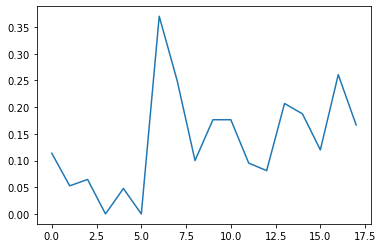

In [532]:
plt.plot(np.arange(len(overlaps)), overlaps)

## only Miss and CR all

In [37]:
day = 1
pre_window = 45
post_window = 45
overlaps = []
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

    iblocks = daily_blocks(data, day)
    iblock = iblocks[0]
    block = data[0, iblocks[0]]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    NT, NA, NF = stim_resp.shape # #trials #axonns #frames

    performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
    print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

    stim = np.ones(cues.shape)
    miss_idx = np.where(outcomes==2)[0]
    cr_idx = np.where(outcomes==4)[0]
    miss_cr_idx = np.hstack([miss_idx, cr_idx])
    stim[miss_idx] = 1
    stim[cr_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
    
    miss_amount = len(miss_idx)
    cr_amount = len(cr_idx)
    print('Miss={}, CR={}'.format(miss_amount, cr_amount))
    valid_amount = min(miss_amount, cr_amount)
    random.seed(0)
    np.random.seed(0)
    miss_idx = miss_idx[np.random.choice(np.arange(miss_amount), size=int(valid_amount), replace=False).astype('int')]
    cr_idx = cr_idx[np.random.choice(np.arange(cr_amount), size=valid_amount, replace=False).astype('int')]
    valid_idx = np.hstack([miss_idx, cr_idx])
    print('Miss={}, CR={}'.format(len(valid_idx)/2, len(valid_idx)/2))
    
    if len(valid_idx) < 6:
        print('continue')
        continue
    spks = stim_resp.reshape(stim_resp.shape[0], -1)
    acc, weights = classifier(spks[valid_idx], stim[valid_idx])
    stim_weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    
    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

    im_axon_ind_block1 = isort[-int(NA*0.1):] # top 10%

    iblock = iblocks[-1]
    block = data[0, iblocks[-1]]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

    NT, NA, NF = stim_resp.shape # #trials #axonns #frames

    performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
    print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

    stim = np.ones(cues.shape)
    miss_idx = np.where(outcomes==2)[0]
    cr_idx = np.where(outcomes==4)[0]
    miss_cr_idx = np.hstack([miss_idx, cr_idx])
    stim[miss_idx] = 1
    stim[cr_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
    
    miss_amount = len(miss_idx)
    cr_amount = len(cr_idx)
    print('Miss={}, CR={}'.format(miss_amount, cr_amount))
    valid_amount = min(miss_amount, cr_amount)
    random.seed(0)
    np.random.seed(0)
    miss_idx = miss_idx[np.random.choice(np.arange(miss_amount), size=int(valid_amount), replace=False).astype('int')]
    cr_idx = cr_idx[np.random.choice(np.arange(cr_amount), size=valid_amount, replace=False).astype('int')]
    valid_idx = np.hstack([miss_idx, cr_idx])
    print('Miss={}, CR={}'.format(len(valid_idx)/2, len(valid_idx)/2))
    
    if len(valid_idx) < 6:
        print('continue')
        continue
    spks = stim_resp.reshape(stim_resp.shape[0], -1)
    acc, weights = classifier(spks[valid_idx], stim[valid_idx])
    stim_weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)

    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))

    im_axon_ind_block3 = isort[-int(NA*0.1):] # top 10%

    avg_diff = np.zeros((len(iblocks), 2)) # sorted block, block, lick or not
    for i, iblock in enumerate(iblocks):
        block = data[0, iblock]
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)

        target_ind = np.where(outcomes==2)[0]
        foil_ind = np.where(outcomes==4)[0]
        im_resp = stim_resp[:, im_axon_ind_block1, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))

        im_resp = stim_resp[:, im_axon_ind_block3, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0))
        diff = block3_diff - block1_diff
        avg_diff[i, 1] = np.mean(diff[45:60])

        target_ind = np.where(outcomes==1)[0]
        foil_ind = np.where(outcomes==3)[0]
        im_resp = stim_resp[:, im_axon_ind_block1, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block1_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 

        im_resp = stim_resp[:, im_axon_ind_block3, :]
        im_target_spks_avg = np.mean(im_resp[target_ind], axis=0)
        im_foil_spks_avg = np.mean(im_resp[foil_ind], axis=0)
        # block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) / (np.max(np.mean(im_target_spks_avg, axis=0)) + np.max(np.mean(im_foil_spks_avg, axis=0)))
        block3_diff = (np.mean(im_target_spks_avg, axis=0) - np.mean(im_foil_spks_avg, axis=0)) 
        diff = block3_diff - block1_diff
        avg_diff[i, 0] = np.mean(diff[45:60])
    overlap_axons = len(np.intersect1d( im_axon_ind_block3,  im_axon_ind_block1)) / len(im_axon_ind_block1)
    overlaps.append(overlap_axons)
    plt.figure(figsize=(6,5))
    x = np.arange(1,len(iblocks)+1)
    plt.bar(x, avg_diff[:, 0], 0.2, label='Hit-FA')
    plt.bar(x+0.2, avg_diff[:, 1], 0.2, label='Miss-CR')
    plt.legend()
    plt.xticks(x)
    plt.title('difference in axon selectivity block1 - block3 \n (top contribute axons for Miss and CR), day {}, {}, overlap={:.2f}%'.format(day, mouse_name, overlap_axons*100))
    fig_save_path = os.path.join('figures', 'contri-diff-Miss-CR_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 47.00%]
Miss=10, CR=7
Miss=7.0, CR=7.0
accuracy predicting stimulus identity on test set:  0.5399999999999999
[block 2, behavior performance 53.00%]
Miss=40, CR=43
Miss=40.0, CR=40.0
accuracy predicting stimulus identity on test set:  0.5259259259259259
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 3, behavior performance 51.00%]
Miss=9, CR=10
Miss=9.0, CR=9.0
accuracy predicting stimulus identity on test set:  0.7166666666666666
[block 5, behavior performance 55.00%]
Miss=23, CR=28
Miss=23.0, CR=23.0
accuracy predicting stimulus identity on test set:  0.525
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[block 6, behavior performance 54.00%]
Miss=2, CR=6
Miss=2.0, CR=2.0
continue
-------------------day 5---------------------
******** predict with activities i

In [ ]:
### all

# day 1

In [533]:
day = 7
pre_window = 45
post_window = 45
print('-------------------day {}---------------------'.format(day))
print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

daily_stim_weights = []
daily_prelick_weights = []
daily_stim_accs = []
daily_prelick_accs = []
behavior_acc = []
iblocks = daily_blocks(data, day)
for iblock in iblocks:
    
    block = data[0, iblock]
    # normalize doesn't have much effect on the result, so set it to False
    cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)
    NT, NA, NF = stim_resp.shape # #trials #axonns #frames
    print(stim_resp.shape)
    
    performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
    behavior_acc.append(performance)
    print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

    stim = np.ones(cues.shape)
    stim[np.where(cues==2)] = 0 
    stim[np.where(cues==4)] = 0
    stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

    spks = stim_resp.reshape(stim_resp.shape[0], -1)
    acc, weights = classifier(spks, stim)
    stim_weights = weights.reshape((NA, NF))
    daily_stim_weights.append(stim_weights)
    daily_stim_accs.append(acc)
    print('accuracy predicting stimulus identity on test set: ', acc)
    
    prelick = (np.sum(alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
    prelick = np.multiply((prelick == 1), 1)
    acc, weights = classifier(spks, prelick)
    prelick_weights = weights.reshape((NA, NF))
    daily_prelick_weights.append(prelick_weights)
    daily_prelick_accs.append(acc)
    print('accuracy predicting prelick on test set: ', acc)

-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
(100, 321, 90)
[block 13, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.5647058823529412
accuracy predicting prelick on test set:  0.788235294117647
(100, 321, 90)
[block 14, behavior performance 50.00%]
accuracy predicting stimulus identity on test set:  0.45588235294117646
no avalible binary labels for classifier


TypeError: cannot unpack non-iterable bool object

In [ ]:
plt.figure(figsize=(5*len(iblocks), 5))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_stim_weights[i]
    plt.plot(np.arange(w.shape[-1]), np.mean(w, axis=0))
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_stim_accs[i], behavior_acc[i]*100))
    plt.axvline(pre_window, color='gray', linestyle=':')
plt.suptitle('stimulus classifier weights, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5*len(iblocks), 5))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_prelick_weights[i]
    plt.plot(np.arange(w.shape[-1]), np.mean(w, axis=0))
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_prelick_accs[i], behavior_acc[i]*100))
    plt.axvline(pre_window, color='gray', linestyle=':')
plt.suptitle('prelick classifier weights, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [ ]:
# after running day 1 section
stim_weights = daily_stim_weights[0]
isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))
plt.figure(figsize=(5*len(iblocks), 6))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_stim_weights[i]
    low = np.mean(w) - 2*np.std(w)
    high = np.mean(w) + 2*np.std(w)
    plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
    plt.colorbar()
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_stim_accs[i], behavior_acc[i]*100))
plt.suptitle('stimulus classifier weights, sorted by block 1 contribution, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5*len(iblocks), 6))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_prelick_weights[i]
    low = np.mean(w) - 2*np.std(w)
    high = np.mean(w) + 2*np.std(w)
    plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
    plt.colorbar()
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_prelick_accs[i], behavior_acc[i]*100))
plt.suptitle('prelick classifier weights, sorted by block 1 contribution, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [ ]:
# after running day 1 section
stim_weights = daily_stim_weights[-1]
isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))
plt.figure(figsize=(5*len(iblocks), 6))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_stim_weights[i]
    low = np.mean(w) - 2*np.std(w)
    high = np.mean(w) + 2*np.std(w)
    plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
    plt.colorbar()
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_stim_accs[i], behavior_acc[i]*100))
plt.suptitle('stimulus classifier weights, sorted by block 3 contribution, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5*len(iblocks), 6))
for i in range(len(iblocks)):
    plt.subplot(1,len(iblocks),i+1)
    w = daily_prelick_weights[i]
    low = np.mean(w) - 2*np.std(w)
    high = np.mean(w) + 2*np.std(w)
    plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
    plt.colorbar()
    plt.title('block {}, decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_prelick_accs[i], behavior_acc[i]*100))
plt.suptitle('prelick classifier weights, sorted by block 3 contribution, day {}, {}'.format(day, mouse_name))
plt.tight_layout()

## all

In [593]:
day = 7
pre_window = 45
post_window = 45
days = []
blocks = []
stim_accs = []
prelick_accs = []
for day in valid_days:
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))

    iblocks = daily_blocks(data, day)
    daily_stim_weights = []
    daily_prelick_weights = []
    daily_stim_accs = []
    daily_prelick_accs = []
    behavior_acc = []
    for iblock in iblocks:
        block = data[0, iblock]
        # normalize doesn't have much effect on the result, so set it to False
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, post_window], normalize=True, dff=False)
        NT, NA, NF = stim_resp.shape # #trials #axonns #frames

        performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
        behavior_acc.append(performance)
        print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))

        stim = np.ones(cues.shape)
        stim[np.where(cues==2)] = 0 
        stim[np.where(cues==4)] = 0
        stim = np.multiply((stim == 1), 1) # target: 1    foil: 0, regardless of probe or reinforce trial

        spks = stim_resp.reshape(stim_resp.shape[0], -1)
        stim_acc, stim_weights = classifier(spks, stim)
        
        prelick = (np.sum(alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
        prelick = np.multiply((prelick == 1), 1)
        prelick_acc, prelick_weights = classifier(spks, prelick)
        stim_weights = stim_weights.reshape((NA, NF))
        daily_stim_weights.append(stim_weights)
        daily_stim_accs.append(stim_acc)
        print('accuracy predicting stimulus identity on test set: ', stim_acc)
        days.append(day)
        blocks.append(iblock)
        stim_accs.append(stim_acc)
        prelick_weights = prelick_weights.reshape((NA, NF))
        daily_prelick_weights.append(prelick_weights)
        daily_prelick_accs.append(prelick_acc)
        print('accuracy predicting prelick on test set: ', prelick_acc)
        prelick_accs.append(prelick_acc)
    
    stim_weights = daily_stim_weights[0]
    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))
    plt.figure(figsize=(10*len(blocks), 12))
    nblocks = len(daily_stim_weights)
    for i in range(nblocks):
        plt.subplot(2,nblocks*2,i+1)
        w = daily_stim_weights[i]
        low = np.mean(w) - 2*np.std(w)
        high = np.mean(w) + 2*np.std(w)
        plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
        plt.colorbar()
        plt.title('stim(sort by b1), block {}\n decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_stim_accs[i]*100, behavior_acc[i]*100))

        plt.subplot(2,nblocks*2,nblocks+i+1)
        w = daily_prelick_weights[i]
        low = np.mean(w) - 2*np.std(w)
        high = np.mean(w) + 2*np.std(w)
        plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
        plt.colorbar()
        plt.title('prelick(sort by b1), block {}\n decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_prelick_accs[i]*100, behavior_acc[i]*100))

    stim_weights = daily_stim_weights[-1]
    isort = np.argsort(np.mean(stim_weights[:, pre_window:(pre_window+15)], axis=1))
    for i in range(nblocks):
        plt.subplot(2,nblocks*2,2*nblocks+i+1)
        w = daily_stim_weights[i]
        low = np.mean(w) - 2*np.std(w)
        high = np.mean(w) + 2*np.std(w)
        plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
        plt.colorbar()
        plt.title('stim(sort by b3), block {}\n decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_stim_accs[i]*100, behavior_acc[i]*100))

        plt.subplot(2,len(blocks)*2,3*len(blocks)+i+1)
        w = daily_prelick_weights[i]
        low = np.mean(w) - 2*np.std(w)
        high = np.mean(w) + 2*np.std(w)
        plt.imshow(w[isort], cmap='bwr', vmin=low, vmax=high)
        plt.colorbar()
        plt.title('prelick(sort by b3), block {}\n decode acc={:.2f}%, performance={:.2f}%'.format(i+1, daily_prelick_accs[i]*100, behavior_acc[i]*100))
    plt.suptitle('stimulus or prelick classifier weights, sorted by block 1 or 3 contribution, day {}, {}'.format(day, mouse_name))
    plt.tight_layout()
    fig_save_path = os.path.join('figures', 'contri-sorted-axons_{}_day-{}'.format(mouse_name, day))
    plt.savefig(fig_save_path, dpi=100)
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 47.00%]
accuracy predicting stimulus identity on test set:  0.7176470588235295
accuracy predicting prelick on test set:  0.6823529411764706
[block 1, behavior performance 53.00%]
accuracy predicting stimulus identity on test set:  0.6588235294117648
accuracy predicting prelick on test set:  0.7941176470588236
[block 2, behavior performance 53.00%]
accuracy predicting stimulus identity on test set:  0.6058823529411764
accuracy predicting prelick on test set:  0.8411764705882353
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 3, behavior performance 51.00%]
accuracy predicting stimulus identity on test set:  0.6411764705882353
accuracy predicting prelick on test set:  0.7411764705882353
[block 4, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.6352941176470589
accuracy predict

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_32436/554120798.py:92: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[block 14, behavior performance 52.00%]
accuracy predicting stimulus identity on test set:  0.5470588235294118
accuracy predicting prelick on test set:  0.8176470588235294
[block 15, behavior performance 56.00%]
accuracy predicting stimulus identity on test set:  0.5264705882352941
accuracy predicting prelick on test set:  0.7676470588235293
[block 16, behavior performance 70.00%]
accuracy predicting stimulus identity on test set:  0.65
accuracy predicting prelick on test set:  0.8205882352941176


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_32436/554120798.py:92: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[block 17, behavior performance 54.00%]
accuracy predicting stimulus identity on test set:  0.7205882352941176
accuracy predicting prelick on test set:  0.8176470588235295
[block 18, behavior performance 68.00%]
accuracy predicting stimulus identity on test set:  0.7588235294117647
accuracy predicting prelick on test set:  0.8764705882352942
-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
[block 19, behavior performance 55.00%]
accuracy predicting stimulus identity on test set:  0.623529411764706
accuracy predicting prelick on test set:  0.761764705882353
[block 20, behavior performance 61.00%]
accuracy predicting stimulus identity on test set:  0.7029411764705882
accuracy predicting prelick on test set:  0.788235294117647
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[block 21, behavior performanc

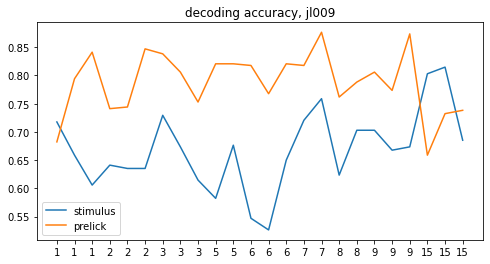

In [594]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(stim_accs)), stim_accs, label='stimulus')
plt.plot(np.arange(len(stim_accs)), prelick_accs, label='prelick')
plt.xticks(np.arange(len(stim_accs)), labels=days)
plt.legend()
plt.title('decoding accuracy, {}'.format(mouse_name))
plt.show()

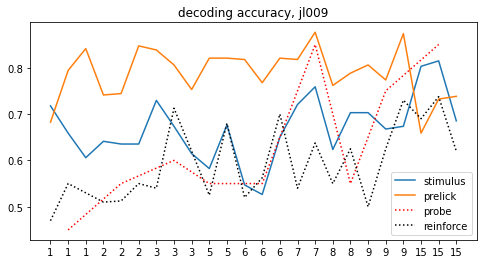

In [595]:
ptrue, rtrue, fnames = behavior_performance(mouse_name, disk)
valid_ptrue = []
valid_rtrue = []
for iblock in blocks:
    block = data[0, iblock]
    fname = block['behaviorfilename']
    fname = fname[0] + '.txt'
    ind = list(fnames).index(fname)
    valid_ptrue.append(ptrue[ind])
    valid_rtrue.append(rtrue[ind])
valid_ptrue = np.array(valid_ptrue)
valid_rtrue = np.array(valid_rtrue)
x = np.arange(len(stim_accs))
plt.figure(figsize=(8, 4))
p_nonzero = np.where(valid_ptrue>0)
r_nonzero = np.where(valid_rtrue>0)
plt.plot(x, stim_accs, label='stimulus')
plt.plot(x, prelick_accs, label='prelick')
plt.plot(x[p_nonzero], valid_ptrue[p_nonzero], label='probe', color='red', linestyle=':')
plt.plot(x[r_nonzero], valid_rtrue[r_nonzero], label='reinforce', color='black', linestyle=':')
plt.xticks(x, labels=days)
plt.legend()
plt.title('decoding accuracy, {}'.format(mouse_name))
plt.show()

# axon contribution in Miss and CR

In [10]:
W_stim = np.zeros((len(valid_days), 90))
pre_window = 45
accs = []
stim_weights = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    NT, NA, NF = daily_responses.shape

    stim = np.ones(daily_cues.shape)
    stim[np.where(daily_outcomes==2)] = 1
    stim[np.where(daily_outcomes==4)] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
    print('Miss={}, CR={}'.format(np.sum(stim), len(stim) - np.sum(stim)))
    
    spks = daily_responses.reshape(daily_responses.shape[0], -1)

    random.seed(0)
    np.random.seed(0)
    itrain = np.random.choice(np.arange(NT), size=int(NT*2/3), replace=False)
    itest = np.setxor1d(np.arange(NT), itrain)

    acc, weights = classifier(spks, stim)
    weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    stim_weights.append(weights)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
Miss=219.0, CR=81.0
accuracy predicting stimulus identity on test set:  0.728
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
Miss=232.0, CR=68.0
accuracy predicting stimulus identity on test set:  0.798
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
Miss=219.0, CR=81.0
accuracy predicting stimulus identity on test set:  0.7520000000000001
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
Miss=177.0, CR=23.0
accuracy predicting stimulus identity on test set:  0.9328358208955223
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
Miss=252.0, CR=48.0
accuracy predicting stimulus identity on test set:  0.882
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
Miss=150.0, CR

In [11]:
for i, day in enumerate(valid_days):
    w = stim_weights[i]
    print(w.shape)

(175, 90)
(141, 90)
(205, 90)
(158, 90)
(169, 90)
(171, 90)
(187, 90)
(198, 90)
(180, 90)


Text(0.5, 1.0, 'stimulus weights from Miss and CR trials, jl009')

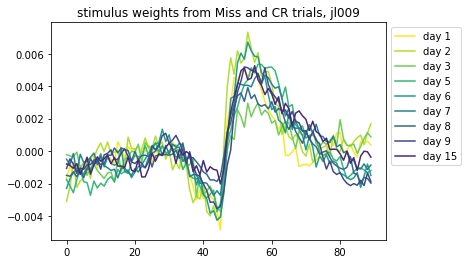

In [12]:
# from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    w = stim_weights[i]
    w = np.mean(w, axis=0)
    # y = W_stim[i] - np.mean(W_stim[i, :45])
    # yhat = savgol_filter(y, 21, 2)
    plt.plot(np.arange(NF), w, label='day {}'.format(day), color=cmap(i/len(valid_days[:15])))
# plt.ylim([-0.003, 0.005])
plt.legend(bbox_to_anchor=(1, 1))
plt.title('stimulus weights from Miss and CR trials, {}'.format(mouse_name))

## decoding accuracy with same amount of Miss and CR

In [42]:
W_stim = np.zeros((len(valid_days), 90))
pre_window = 45
accs = []
stim_weights = []
for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to False
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            daily_cues.append(cues)
            daily_outcomes.append(outcomes)
            daily_responses.append(stim_resp)
            daily_firstlicks.append(firstlicks)
            daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_responses = np.vstack(daily_responses)
        daily_alllicks = np.vstack(daily_alllicks)

    nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
    inotnan = np.where(nanflag==0)
    daily_responses = daily_responses[inotnan]
    daily_cues = daily_cues[inotnan]
    daily_outcomes = daily_outcomes[inotnan]
    daily_alllicks = daily_alllicks[inotnan]
    
    NT, NA, NF = daily_responses.shape

    stim = np.ones(daily_cues.shape)
    miss_idx = np.where(daily_outcomes==2)[0]
    cr_idx = np.where(daily_outcomes==4)[0]
    miss_cr_idx = np.hstack([miss_idx, cr_idx])
    stim[miss_idx] = 1
    stim[cr_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
    
    miss_amount = len(miss_idx)
    cr_amount = len(cr_idx)
    print('Miss={}, CR={}'.format(miss_amount, cr_amount))
    valid_amount = min(miss_amount, cr_amount)
    random.seed(0)
    np.random.seed(0)
    miss_idx = miss_idx[np.random.choice(np.arange(miss_amount), size=int(valid_amount), replace=False).astype('int')]
    cr_idx = cr_idx[np.random.choice(np.arange(cr_amount), size=valid_amount, replace=False).astype('int')]
    valid_idx = np.hstack([miss_idx, cr_idx])
    print('Miss={}, CR={}'.format(len(valid_idx)/2, len(valid_idx)/2))
    
    spks = daily_responses.reshape(daily_responses.shape[0], -1)

    itrain = np.random.choice(np.arange(valid_amount), size=int(valid_amount*2/3), replace=False)
    itest = np.setxor1d(np.arange(valid_amount), itrain)
    itrain = valid_idx[itrain]
    itest = valid_idx[itest]

    acc, weights = classifier(spks, stim)
    weights = weights.reshape((NA, NF))
    print('accuracy predicting stimulus identity on test set: ', acc)
    accs.append(acc)
    stim_weights.append(weights)

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
Miss=78, CR=81
Miss=78.0, CR=78.0
accuracy predicting stimulus identity on test set:  0.728
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
Miss=60, CR=68
Miss=60.0, CR=60.0
accuracy predicting stimulus identity on test set:  0.798
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
Miss=46, CR=81
Miss=46.0, CR=46.0
accuracy predicting stimulus identity on test set:  0.7520000000000001
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
Miss=2, CR=23
Miss=2.0, CR=2.0
accuracy predicting stimulus identity on test set:  0.9328358208955223
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
Miss=20, CR=48
Miss=20.0, CR=20.0
accuracy predicting stimulus identity on test set:  0.882
-------------------day 7------------------

In [43]:
print(accs, len(accs))

[0.728, 0.798, 0.7520000000000001, 0.9328358208955223, 0.882, 0.8641791044776118, 0.8208955223880597, 0.8629999999999999, 0.796] 9


In [40]:
print(accs, len(accs))

[0.6359999999999999, 0.6439999999999999, 0.5641791044776119, 0.6223880597014924, 0.5656716417910448, 0.5447761194029852, 0.7507462686567165, 0.6298507462686567, 0.8099999999999999, 0.7970149253731342, 0.5835820895522389, 0.6469999999999999, 0.7671641791044775, 0.8194029850746268, 0.812, 0.6388059701492537, 0.751, 0.708955223880597] 18


In [45]:
print(valid_days)

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]


In [41]:
print(valid_days)

[1, 2, 3, 5, 6, 7, 8, 9, 15]


Text(0.5, 1.0, 'stimulus decoding accuracy with only Miss and CR trials(same number), fz017')

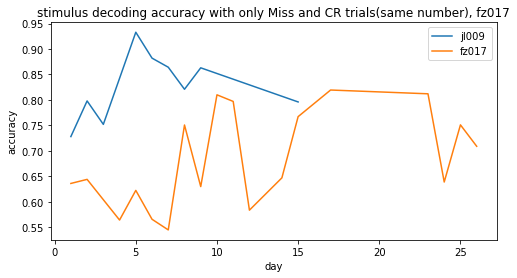

In [47]:
plt.figure(figsize=(8, 4))
fz017_x = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
jl009_x = [1, 2, 3, 5, 6, 7, 8, 9, 15]
fz017_accs = [0.6359999999999999, 0.6439999999999999, 0.5641791044776119, 0.6223880597014924, 0.5656716417910448, 0.5447761194029852, 0.7507462686567165, 0.6298507462686567, 0.8099999999999999, 0.7970149253731342, 0.5835820895522389, 0.6469999999999999, 0.7671641791044775, 0.8194029850746268, 0.812, 0.6388059701492537, 0.751, 0.708955223880597]
jl009_accs = [0.728, 0.798, 0.7520000000000001, 0.9328358208955223, 0.882, 0.8641791044776118, 0.8208955223880597, 0.8629999999999999, 0.796]
plt.plot(jl009_x, jl009_accs, label='jl009')
plt.plot(fz017_x, fz017_accs, label='fz017')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.legend()
plt.title('stimulus decoding accuracy with only Miss and CR trials(same number), {}'.format(mouse_name))

Text(0.5, 1.0, 'stimulus weights from Miss and CR trials(same amount), fz017')

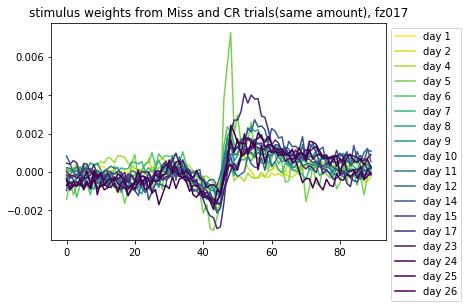

In [28]:
# from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')
for i, day in enumerate(valid_days):
    w = stim_weights[i]
    w = np.mean(w, axis=0)
    # y = W_stim[i] - np.mean(W_stim[i, :45])
    # yhat = savgol_filter(y, 21, 2)
    plt.plot(np.arange(NF), w, label='day {}'.format(day), color=cmap(i/len(valid_days[:15])))
# plt.ylim([-0.003, 0.005])
plt.legend(bbox_to_anchor=(1, 1))
plt.title('stimulus weights from Miss and CR trials(same amount), {}'.format(mouse_name))

ValueError: x and y must have same first dimension, but have shapes (9,) and (18,)

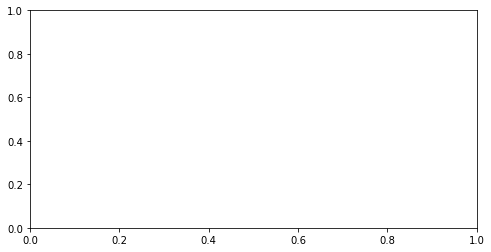

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(valid_days, accs)
plt.xlabel('day')
plt.title('stimulus decoding accuracy with only Miss and CR trials(same number), {}'.format(mouse_name))

# peirod 1 vs period 2

In [264]:
day = 1
pre_window = 45
post_window = 45

for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
        
    rl_performance = []
    pb_performance = []
    blocks = []
    days = []
    all_accs = []
    all_weights = []
    p1_stim_accs = []
    p1_stim_weights = []
    p2_lick_accs = []
    p2_lick_weights = []
    p2_stim_accs = []
    p2_stim_weights = []
    p1_lick_accs = []
    p1_lick_weights = []
    p3_lick_accs = []
    p3_lick_weights = []
    p3_stim_accs = []
    p3_stim_weights = []
    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)
                block = data[0, iblock]
                # normalize doesn't have much effect on the result, so set it to OBlse
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)

                NT, NA, NF = stim_resp.shape
                performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
                print('[block {}, behavior performance {:.2f}%]'.format(iblock, performance*100))
                rl_performance.append(performance)
                pb_ind = np.hstack([np.where(cues==3)[0], np.where(cues==4)[0]])
                pb_outcomes = outcomes[pb_ind]
                performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
                pb_performance.append(performance)

                stim = np.ones(cues.shape)
                OA_idx = np.where(cues==2)[0]
                OB_idx = np.where(cues==4)[0]
                stim[OA_idx] = 0
                stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

                p1_frange = np.arange(pre_window, (pre_window+15))
                p1_stim_resp = stim_resp[:, :, p1_frange]
                spks = p1_stim_resp.reshape(p1_stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim)
                weights = weights.reshape((NA, len(p1_frange)))
                p1_stim_accs.append(acc)
                p1_stim_weights.append(weights)
                print('accuracy predicting stimulus identity(Period 1): ', acc)
    #             postlick = (np.sum(alllicks[:, p1_frange], axis=1) > 0)
    #             postlick = np.multiply((postlick == 1), 1)
                postlick = np.zeros(outcomes.shape)
                postlick[np.where(outcomes==1)] = 1
                postlick[np.where(outcomes==3)] = 1
                acc, weights = classifier(spks, postlick)
                print('accuracy predicting lick(Period 1): ', acc)
                p1_lick_accs.append(acc)
                p1_lick_weights.append(weights)

                p2_frange = np.arange((pre_window+15), (pre_window+30))
                p2_stim_resp = stim_resp[:, :, p2_frange]
                spks = p2_stim_resp.reshape(p2_stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim)
                weights = weights.reshape((NA, len(p2_frange)))
                p2_stim_accs.append(acc)
                p2_stim_weights.append(weights)
                print('accuracy predicting stimulus identity(Period 2): ', acc)
    #             postlick = (np.sum(alllicks[:, p1_frange], axis=1) > 0)
    #             postlick = np.multiply((postlick == 1), 1)
                postlick = np.zeros(outcomes.shape)
                postlick[np.where(outcomes==1)] = 1
                postlick[np.where(outcomes==3)] = 1
                acc, weights = classifier(spks, postlick)
                print('accuracy predicting lick(Period 2): ', acc)
                p2_lick_accs.append(acc)
                p2_lick_weights.append(weights)

                p3_frange = np.arange((pre_window+30), (pre_window+45))
                p3_stim_resp = stim_resp[:, :, p3_frange]
                spks = p3_stim_resp.reshape(p3_stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim)
                weights = weights.reshape((NA, len(p3_frange)))
                p3_stim_accs.append(acc)
                p3_stim_weights.append(weights)
                print('accuracy predicting stimulus identity(Period 2): ', acc)
    #             postlick = (np.sum(alllicks[:, p1_frange], axis=1) > 0)
    #             postlick = np.multiply((postlick == 1), 1)
                postlick = np.zeros(outcomes.shape)
                postlick[np.where(outcomes==1)] = 1
                postlick[np.where(outcomes==3)] = 1
                acc, weights = classifier(spks, postlick)
                print('accuracy predicting lick(Period 2): ', acc)
                p3_lick_accs.append(acc)
                p3_lick_weights.append(weights)

    n = 3
    cm = plt.get_cmap('viridis') 
    color = cm(np.linspace(0, 1, n))
    color = color[::-1]

    matplotlib.style.use('default')
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.figure(figsize=(10, 5))
    x = np.arange(len(blocks))
    xx, yy = remove_false(x, p1_stim_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[0], label='p1, stim')
    xx, yy = remove_false(x, p1_lick_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
    xx, yy = remove_false(x, p2_stim_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[1], label='p2, stim')
    xx, yy = remove_false(x, p2_lick_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
    plt.xticks(x, labels=days, fontsize=8)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('decoding accuracy, smooth, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.4,1])
    plt.legend(loc=4)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figures/decoding_acc_p1p2_smooth_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(10, 5))
    x = np.arange(len(blocks))
    xx, yy = remove_false(x, p1_stim_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[0], label='p1, stim')
    xx, yy = remove_false(x, p1_lick_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
    xx, yy = remove_false(x, p2_stim_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[1], label='p2, stim')
    xx, yy = remove_false(x, p2_lick_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
    xx, yy = remove_false(x, p3_stim_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[2], label='p3, stim')
    xx, yy = remove_false(x, p3_lick_accs)
    xx, yy = smooth_line(xx, yy)
    plt.plot(xx, yy, color=color[2], linestyle=':', label='p3, lick')
    plt.xticks(x, labels=days, fontsize=8)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('decoding accuracy, smooth, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.4,1])
    plt.legend(loc=4)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figures/decoding_acc_p1p2p3_smooth_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(10, 5))
    x = np.arange(len(blocks))
    xx, yy = remove_false(x, p1_stim_accs)
    plt.plot(xx, yy, color=color[0], label='p1, stim')
    xx, yy = remove_false(x, p1_lick_accs)
    plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
    xx, yy = remove_false(x, p2_stim_accs)
    plt.plot(xx, yy, color=color[1], label='p2, stim')
    xx, yy = remove_false(x, p2_lick_accs)
    plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
    xx, yy = remove_false(x, p3_stim_accs)
    plt.plot(xx, yy, color=color[2], label='p3, stim')
    xx, yy = remove_false(x, p3_lick_accs)
    plt.plot(xx, yy, color=color[2], linestyle=':', label='p3, lick')
    plt.xticks(x, labels=days, fontsize=8)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.4,1])
    plt.legend(loc=4)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figures/decoding_acc_p1p2p3_raw_{}'.format(mouse_name))
    plt.close()

    plt.figure(figsize=(10, 5))
    x = np.arange(len(blocks))
    xx, yy = remove_false(x, p1_stim_accs)
    plt.plot(xx, yy, color=color[0], label='p1, stim')
    xx, yy = remove_false(x, p1_lick_accs)
    plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
    xx, yy = remove_false(x, p2_stim_accs)
    plt.plot(xx, yy, color=color[1], label='p2, stim')
    xx, yy = remove_false(x, p2_lick_accs)
    plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
    plt.xticks(x, labels=days, fontsize=8)
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.4,1])
    plt.legend(loc=4)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figures/decoding_acc_p1p2_raw_{}'.format(mouse_name))
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 47.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7294117647058823
valid samples: 34
accuracy predicting lick(Period 1):  0.4416666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5441176470588236
valid samples: 34
accuracy predicting lick(Period 2):  0.5833333333333334
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5823529411764706
valid samples: 34
accuracy predicting lick(Period 2):  0.5583333333333333
[block 1, behavior performance 53.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7088235294117647
valid samples: 82
accuracy predicting lick(Period 1):  0.5928571428571429
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6529411764705882
valid samples: 82
accuracy predicting lick(Period 2):  0.657142857142857
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6029411764705882
valid samples: 82
accuracy predicting lick(Period 2):  0.6964285714285714
[block 2,

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.623529411764706
valid samples: 34
accuracy predicting lick(Period 1):  0.7333333333333334
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5323529411764706
valid samples: 34
accuracy predicting lick(Period 2):  0.7749999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5117647058823529
valid samples: 34
accuracy predicting lick(Period 2):  0.8583333333333332
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 3, behavior performance 51.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6647058823529413
valid samples: 38
accuracy predicting lick(Period 1):  0.6153846153846154
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5441176470588236
valid samples: 38
accuracy predicting lick(Period 2):  0.8076923076923077
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6147058823529411
valid samples: 38
accuracy predicting lick(Period 2):  0.7615384615384616
[block 4, behavior performance 52.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.661764705882353
valid samples: 84
accuracy predicting lick(Period 1):  0.5678571428571428
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6029411764705883
valid samples: 84
accuracy predicting lick(Period 2):  0.6785714285714286
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5676470588235294
valid samples: 84
accuracy predicting lick(Period 2):  0.6892857142857143
[block 5,

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6823529411764706
valid samples: 98
accuracy predicting lick(Period 1):  0.7181818181818183
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6500000000000001
valid samples: 98
accuracy predicting lick(Period 2):  0.8212121212121211
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5882352941176471
valid samples: 98
accuracy predicting lick(Period 2):  0.809090909090909
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[block 6, behavior performance 54.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7264705882352942
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6352941176470589
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5441176470588235
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 7, behavior performance 69.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6764705882352942
valid samples: 70
accuracy predicting lick(Period 1):  0.6708333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941176
valid samples: 70
accuracy predicting lick(Period 2):  0.7291666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5911764705882353
valid samples: 70
accuracy predicting lick(Period 2)

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5764705882352941
valid samples: 32
accuracy predicting lick(Period 1):  0.8909090909090909
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529411
valid samples: 32
accuracy predicting lick(Period 2):  0.9181818181818182
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5029411764705882
valid samples: 32
accuracy predicting lick(Period 2):  0.8181818181818181
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[block 11, behavior performance 53.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7441176470588236
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529411
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identi

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7941176470588236
valid samples: 44
accuracy predicting lick(Period 1):  0.8666666666666666
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6294117647058824
valid samples: 44
accuracy predicting lick(Period 2):  0.8
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4970588235294118
valid samples: 44
accuracy predicting lick(Period 2):  0.6466666666666667
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[block 14, behavior performance 52.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5617647058823529
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5352941176470589
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5294117647058825
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 15, behavior performance 56.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5205882352941176
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5970588235294118
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5294117647058825
no avalible binary labels for c

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5941176470588235
valid samples: 84
accuracy predicting lick(Period 1):  0.7892857142857143
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5970588235294118
valid samples: 84
accuracy predicting lick(Period 2):  0.8142857142857143
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5705882352941176
valid samples: 84
accuracy predicting lick(Period 2):  0.7071428571428571
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[block 17, behavior performance 54.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6205882352941176
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6941176470588235
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6588235294117647
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 18, behavior performance 68.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7882352941176471
valid samples: 52
accuracy predicting lick(Period 1):  0.8444444444444444
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6352941176470588
valid samples: 52
accuracy predicting lick(Period 2):  0.8944444444444445
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5941176470588235
valid samples: 52
accuracy predicting lick(Period 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7058823529411765
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529411
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5823529411764705
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 20, behavior performance 61.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7264705882352941
valid samples: 30
accuracy predicting lick(Period 1):  0.72
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941177
valid samples: 30
accuracy predicting lick(Period 2):  0.73
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.538235294117647
valid samples: 30
accuracy predicting lick(Period 2):  0.5399

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7470588235294118
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6235294117647058
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.573529411764706
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 22, behavior performance 65.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6705882352941177
valid samples: 42
accuracy predicting lick(Period 1):  0.7357142857142858
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941177
valid samples: 42
accuracy predicting lick(Period 2):  0.7214285714285715
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6
valid samples: 42
accuracy predicting lick(Period 2):  0.55
[block 

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6558823529411766
valid samples: 74
accuracy predicting lick(Period 1):  0.6519999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7117647058823529
valid samples: 74
accuracy predicting lick(Period 2):  0.784
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5970588235294119
valid samples: 74
accuracy predicting lick(Period 2):  0.692
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[block 38, behavior performance 69.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7558823529411764
valid samples: 38
accuracy predicting lick(Period 1):  0.6846153846153846
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.788235294117647
valid samples: 38
accuracy predicting lick(Period 2):  0.8307692307692308
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6647058823529413
valid samples: 38
accuracy predicting lick(Period 2):  0.6615384615384616
[block 39, behavior performance 76.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7470588235294118
valid samples: 52
accuracy predicting lick(Period 1):  0.8111111111111111
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8205882352941176
valid samples: 52
accuracy predicting lick(Period 2):  0.8444444444444443
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5941176470588235
valid samples: 52
accuracy predicting lick(Period 2):  0.5777777777777777
[block 4

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7352941176470589
valid samples: 28
accuracy predicting lick(Period 1):  0.79
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5970588235294118
valid samples: 28
accuracy predicting lick(Period 2):  0.72
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.55
valid samples: 28
accuracy predicting lick(Period 2):  0.6
-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[block 0, behavior performance 48.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5323529411764706
valid samples: 88
accuracy predicting lick(Period 1):  0.5233333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5235294117647059
valid samples: 88
accuracy predicting lick(Period 2):  0.7333333333333334
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5529411764705883
valid samples: 88
accuracy predicting lick(Period 2):  0.8433333333333334
[block 1, behavior performance 48.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.3764705882352941
valid samples: 40
accuracy predicting lick(Period 1):  0.7857142857142857
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.511764705882353
valid samples: 40
accuracy predicting lick(Period 2):  0.9428571428571428
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.41764705882352937
valid samples: 40
accuracy predicting lick(Period 2):  0.9714285714285715
[block 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.49411764705882344
valid samples: 74
accuracy predicting lick(Period 1):  0.692
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.48235294117647054
valid samples: 74
accuracy predicting lick(Period 2):  0.724
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.49705882352941166
valid samples: 74
accuracy predicting lick(Period 2):  0.8399999999999999
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 3, behavior performance 47.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5264705882352942
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5764705882352941
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7205882352941176
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 4, behavior performance 46.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5235294117647059
valid samples: 76
accuracy predicting lick(Period 1):  0.7461538461538462
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.49411764705882355
valid samples: 76
accuracy predicting lick(Period 2):  0.7461538461538462
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4470588235294118
valid samples: 76
accuracy predicting lick(Period 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5029411764705882
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6470588235294118
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.49411764705882355
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[block 7, behavior performance 48.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5000000000000001
valid samples: 60
accuracy predicting lick(Period 1):  0.78
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5705882352941176
valid samples: 60
accuracy predicting lick(Period 2):  0.775
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6205882352941176
valid samples: 60
accuracy predicting lick(Period 2):  0.805
[block 8, behavior performance 51.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5852941176470587
valid samples: 22
accuracy predicting lick(Period 1):  0.6875
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5264705882352941
valid samples: 22
accuracy predicting lick(Period 2):  0.7
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.48235294117647065
valid samples: 22
accuracy predicting lick(Period 2):  0.775
-------------------day 5---------------------
******** predict with activities in [T-45

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.4911764705882353
valid samples: 50
accuracy predicting lick(Period 1):  0.523529411764706
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5823529411764705
valid samples: 50
accuracy predicting lick(Period 2):  0.6235294117647059
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5617647058823529
valid samples: 50
accuracy predicting lick(Period 2):  0.6352941176470588
[block 10, behavior performance 57.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.42058823529411765
valid samples: 82
accuracy predicting lick(Period 1):  0.6607142857142858
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5264705882352942
valid samples: 82
accuracy predicting lick(Period 2):  0.7821428571428573
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.45588235294117646
valid samples: 82
accuracy predicting lick(Period 2):  0.7392857142857142
------

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5147058823529412
valid samples: 70
accuracy predicting lick(Period 1):  0.7416666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5441176470588235
valid samples: 70
accuracy predicting lick(Period 2):  0.7999999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5852941176470589
valid samples: 70
accuracy predicting lick(Period 2):  0.8166666666666668
[block 12, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.4205882352941176
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5529411764705883
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5264705882352941
no avalible binary labels for classifier
accuracy predicting 

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.4352941176470589
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.44411764705882356
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4352941176470589
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
[block 15, behavior performance 53.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5823529411764706
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7676470588235293
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8088235294117647
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 16, behavior performance 59.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5411764705882354
valid samples: 94
accuracy predicting lick(Period 1):  0.690625
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6205882352941176
valid samples: 94
accuracy predicting lick(Period 2):  0.825
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.46470588235294114
valid samples: 94
accuracy predicting lick(Period 2):  0.8125
-----------

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6147058823529412
valid samples: 32
accuracy predicting lick(Period 1):  0.8272727272727274
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7588235294117647
valid samples: 32
accuracy predicting lick(Period 2):  0.8363636363636365
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8147058823529412
valid samples: 32
accuracy predicting lick(Period 2):  0.8
[block 18, behavior performance 51.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.47352941176470587
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.45294117647058824
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4647058823529412
no avalible binary labels for classifier
accuracy predicting lick(Period 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6058823529411765
valid samples: 34
accuracy predicting lick(Period 1):  0.725
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7588235294117647
valid samples: 34
accuracy predicting lick(Period 2):  0.7333333333333332
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7647058823529411
valid samples: 34
accuracy predicting lick(Period 2):  0.7083333333333334
[block 21, behavior performance 75.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6264705882352941
valid samples: 54
accuracy predicting lick(Period 1):  0.6777777777777778
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941177
valid samples: 54
accuracy predicting lick(Period 2):  0.7388888888888889
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6088235294117647
valid samples: 54
accuracy predicting lick(Period 2):  0.6
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[block 22, behavior performance 52.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.526470588235294
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8558823529411764
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8411764705882353
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 23, behavior performance 62.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5911764705882353
valid samples: 60
accuracy predicting lick(Period 1):  0.9199999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5911764705882353
valid samples: 60
accuracy predicting lick(Period 2):  0.925
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6264705882352942
valid samples: 60
accuracy predicting lick(Period 2):  0.94999999

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6029411764705883
valid samples: 82
accuracy predicting lick(Period 1):  0.8285714285714285
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5
valid samples: 82
accuracy predicting lick(Period 2):  0.8178571428571428
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4970588235294118
valid samples: 82
accuracy predicting lick(Period 2):  0.8035714285714286
[block 25, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5882352941176471
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.44411764705882356
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4117647058823529
no avalible binary labels for classifier
accuracy predicting lick(Period 2)

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6176470588235294
valid samples: 66
accuracy predicting lick(Period 1):  0.740909090909091
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.723529411764706
valid samples: 66
accuracy predicting lick(Period 2):  0.7181818181818181
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6382352941176471
valid samples: 66
accuracy predicting lick(Period 2):  0.6909090909090909
[block 30, behavior performance 71.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6470588235294118
valid samples: 66
accuracy predicting lick(Period 1):  0.8409090909090908
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7176470588235294
valid samples: 66
accuracy predicting lick(Period 2):  0.8363636363636363
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7352941176470588
valid samples: 66
accuracy predicting lick(Period 2):  0.7818181818181819
[block 31

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.38529411764705884
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4676470588235294
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5029411764705882
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[block 32, behavior performance 56.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.638235294117647
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7735294117647059
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8735294117647058
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 33, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.47058823529411764
valid samples: 36
accuracy predicting lick(Period 1):  0.7416666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5705882352941176
valid samples: 36
accuracy predicting lick(Period 2):  0.7249999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5205882352941176
valid samples: 36
accuracy predicting lick(Period 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6441176470588235
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8264705882352941
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.9264705882352942
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 38, behavior performance 65.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.65
valid samples: 46
accuracy predicting lick(Period 1):  0.5875
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8294117647058824
valid samples: 46
accuracy predicting lick(Period 2):  0.74375
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7735294117647058
valid samples: 46
accuracy predicting lick(Period 2):  0.775
[block 39, behavior perform

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7058823529411764
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.9029411764705882
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8382352941176471
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 41, behavior performance 70.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6676470588235295
valid samples: 96
accuracy predicting lick(Period 1):  0.784375
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6117647058823529
valid samples: 96
accuracy predicting lick(Period 2):  0.821875
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5764705882352942
valid samples: 96
accuracy predicting lick(Period 2):  0.796875
-------------------day 23---------------------
******** predict with activities in [T-45, T+45]
[block 55, behavior performance 67.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6382352941176471
valid samples: 34
accuracy predicting lick(Period 1):  0.575
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8176470588235294
valid samples: 34
accuracy predicting lick(Period 2):  0.8083333333333332
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8352941176470589
valid samples: 34
accuracy predicting lick(Period 2):  0.8666666666666666
[block 56, behavior performance 72.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6735294117647059
valid samples: 76
accuracy predicting lick(Period 1):  0.7461538461538462
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7323529411764705
valid samples: 76
accuracy predicting lick(Period 2):  0.7807692307692309
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7705882352941176
valid samples: 76
accuracy predicting lick(Period 2):  0.8576923076923076
[block 57, behavior 

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7617647058823529
valid samples: 60
accuracy predicting lick(Period 1):  0.825
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.811764705882353
valid samples: 60
accuracy predicting lick(Period 2):  0.86
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8441176470588235
valid samples: 60
accuracy predicting lick(Period 2):  0.8699999999999999
-------------------day 24---------------------
******** predict with activities in [T-45, T+45]
[block 58, behavior performance 48.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6735294117647059
valid samples: 80
accuracy predicting lick(Period 1):  0.6740740740740742
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5970588235294118
valid samples: 80
accuracy predicting lick(Period 2):  0.5888888888888889
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5088235294117647
valid samples: 80
accuracy predicting lick(Period 2):  0.7148148148148149
[block 59, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5617647058823529
valid samples: 20
accuracy predicting lick(Period 1):  0.7285714285714286
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5382352941176471
valid samples: 20
accuracy predicting lick(Period 2):  0.8
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5235294117647058
valid samples: 20
accuracy predicting lick(Period 2):  0.7285714285714284
-------------------day

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7235294117647059
valid samples: 52
accuracy predicting lick(Period 1):  0.6833333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941177
valid samples: 52
accuracy predicting lick(Period 2):  0.7222222222222223
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6705882352941177
valid samples: 52
accuracy predicting lick(Period 2):  0.7777777777777778
[block 61, behavior performance 57.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6088235294117647
valid samples: 70
accuracy predicting lick(Period 1):  0.7874999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6558823529411766
valid samples: 70
accuracy predicting lick(Period 2):  0.8541666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5941176470588235
valid samples: 70
accuracy predicting lick(Period 2):  0.8375
[block 62, behavior

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6794117647058824
valid samples: 40
accuracy predicting lick(Period 1):  0.6785714285714286
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8264705882352941
valid samples: 40
accuracy predicting lick(Period 2):  0.5357142857142858
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8411764705882353
valid samples: 40
accuracy predicting lick(Period 2):  0.7071428571428572
-------------------day 26---------------------
******** predict with activities in [T-45, T+45]
[block 63, behavior performance 66.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6323529411764706
valid samples: 60
accuracy predicting lick(Period 1):  0.74
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7294117647058823
valid samples: 60
accuracy predicting lick(Period 2):  0.825
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7058823529411764
valid samples: 60
accuracy predicting lick(Period 2):  0.9199999999999999
[block 64, behavior performance 49.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.4499999999999999
valid samples: 74
accuracy predicting lick(Period 1):  0.6479999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5558823529411765
valid samples: 74
accuracy predicting lick(Period 2):  0.736
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4676470588235294
valid samples: 74
accuracy predicting lick(Period 2):  0.804
-------------------day 1---------------------
******** predi

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5882352941176471
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4676470588235294
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5735294117647058
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 1, behavior performance 43.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5794117647058823
valid samples: 86
accuracy predicting lick(Period 1):  0.7241379310344828
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5529411764705882
valid samples: 86
accuracy predicting lick(Period 2):  0.8551724137931036
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.438235294117647
valid samples: 86
accuracy predicting lick(Period 2):  0.8689655172413794
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 2, behavior performance 53.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6205882352941178
valid samples: 62
accuracy predicting lick(Period 1):  0.8238095238095238
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4911764705882352
valid samples: 62
accuracy predicting lick(Period 2):  0.8238095238095238
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.511764705882353
valid samples: 62
accuracy predicting lick(Period 2):  0.8142857142857143
[block 3, behavior performance 51.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5852941176470587
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5941176470588235
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5088235294117647
no avalible binary labels for classifier
accuracy predicting li

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting lick(Period 1):  0.7130434782608697
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.48235294117647054
valid samples: 68
accuracy predicting lick(Period 2):  0.8086956521739129
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.3647058823529412
valid samples: 68
accuracy predicting lick(Period 2):  0.7
[block 9, behavior performance 62.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.55
valid samples: 76
accuracy predicting lick(Period 1):  0.7999999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5529411764705883
valid samples: 76
accuracy predicting lick(Period 2):  0.8461538461538461
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6852941176470588
valid samples: 76
accuracy predicting lick(Period 2):  0.8692307692307694
[block 10, behavior performance 58.00%]


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6235294117647059
valid samples: 76
accuracy predicting lick(Period 1):  0.7307692307692307
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6176470588235294
valid samples: 76
accuracy predicting lick(Period 2):  0.7846153846153847
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5647058823529412
valid samples: 76
accuracy predicting lick(Period 2):  0.7423076923076923
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[block 21, behavior performance 75.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.8470588235294118
valid samples: 58
accuracy predicting lick(Period 1):  0.795
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7911764705882354
valid samples: 58
accuracy predicting lick(Period 2):  0.9099999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6647058823529413
valid samples: 58
accuracy predicting lick(Period 2):  0.915
[block 22, behavior performance 72.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.9029411764705882
valid samples: 92
accuracy predicting lick(Period 1):  0.7806451612903226
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.8
valid samples: 92
accuracy predicting lick(Period 2):  0.867741935483871
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6411764705882353
valid samples: 92
accuracy predicting lick(Period 2):  0.7290322580645162
[block 23, behavior performance 68.00%]
valid sam

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7176470588235294
valid samples: 44
accuracy predicting lick(Period 1):  0.8400000000000001
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6323529411764707
valid samples: 44
accuracy predicting lick(Period 2):  0.8400000000000001
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.46176470588235297
valid samples: 44
accuracy predicting lick(Period 2):  0.6066666666666667
-------------------day 12---------------------
******** predict with activities in [T-45, T+45]
[block 24, behavior performance 66.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.7147058823529411
valid samples: 56
accuracy predicting lick(Period 1):  0.7052631578947368
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7088235294117646
valid samples: 56
accuracy predicting lick(Period 2):  0.8105263157894737
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6176470588235293
valid samples: 56
accuracy predicting lick(Period 2):  0.7157894736842104
[block 25, behavior performance 80.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.7441176470588236
valid samples: 64
accuracy predicting lick(Period 1):  0.7045454545454545
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7000000000000001
valid samples: 64
accuracy predicting lick(Period 2):  0.8136363636363637
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5941176470588235
valid samples: 64
accuracy predicting lick(Period 2):  0.7090909090909092
-------

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6235294117647059
valid samples: 96
accuracy predicting lick(Period 1):  0.6875
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5735294117647058
valid samples: 96
accuracy predicting lick(Period 2):  0.70625
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.45
valid samples: 96
accuracy predicting lick(Period 2):  0.50625
[block 35, behavior performance 54.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6323529411764707
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.488235294117647
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4470588235294118
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
-------

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.49411764705882355
valid samples: 42
accuracy predicting lick(Period 1):  0.45714285714285713
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5794117647058823
valid samples: 42
accuracy predicting lick(Period 2):  0.7214285714285714
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6794117647058824
valid samples: 42
accuracy predicting lick(Period 2):  0.8357142857142857
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[block 1, behavior performance 55.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.48235294117647054
valid samples: 86
accuracy predicting lick(Period 1):  0.6034482758620691
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4411764705882352
valid samples: 86
accuracy predicting lick(Period 2):  0.7758620689655172
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5
valid samples: 86
accuracy predicting lick(Period 2):  0.7586206896551724
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[block 2, behavior performance 51.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.4764705882352941
valid samples: 74
accuracy predicting lick(Period 1):  0.6439999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5088235294117647
valid samples: 74
accuracy predicting lick(Period 2):  0.72
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529411
valid samples: 74
accuracy predicting lick(Period 2):  0.8160000000000001
[block 3, behavior performance 50.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.6058823529411765
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529412
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.48529411764705876
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[block 4, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.4794117647058823
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.49411764705882355
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7058823529411764
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 5, behavior performance 53.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5147058823529411
valid samples: 70
accuracy predicting lick(Period 1):  0.4625
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5352941176470587
valid samples: 70
accuracy predicting lick(Period 2):  0.7333333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6117647058823531
valid samples: 70
accuracy predicting lick(Period 2):  0.8125
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[block 6, behavior performance 49.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5794117647058824
valid samples: 58
accuracy predicting lick(Period 1):  0.445
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.41764705882352937
valid samples: 58
accuracy predicting lick(Period 2):  0.845
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4911764705882353
valid samples: 58
accuracy predicting lick(Period 2):  0.8099999999999999
[block 7, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6088235294117648
valid samples: 56
accuracy predicting lick(Period 1):  0.6789473684210525
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4970588235294118
valid samples: 56
accuracy predicting lick(Period 2):  0.7894736842105263
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5382352941176471
valid samples: 56
accuracy predicting lick(Period 2):  0.936842105263158
-------------------day 6----------

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5088235294117647
no avalible binary labels for classifier
accuracy predicting lick(Period 1):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4617647058823529
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4852941176470589
no avalible binary labels for classifier
accuracy predicting lick(Period 2):  False
[block 9, behavior performance 51.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6147058823529412
valid samples: 70
accuracy predicting lick(Period 1):  0.7583333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.46470588235294114
valid samples: 70
accuracy predicting lick(Period 2):  0.7749999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4382352941176471
valid samples: 70
accuracy predicting lick(Period 2

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5117647058823529
valid samples: 84
accuracy predicting lick(Period 1):  0.7428571428571429
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.46176470588235297
valid samples: 84
accuracy predicting lick(Period 2):  0.8714285714285716
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.44117647058823534
valid samples: 84
accuracy predicting lick(Period 2):  0.9321428571428572
[block 16, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6294117647058824
valid samples: 20
accuracy predicting lick(Period 1):  0.5857142857142856
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5029411764705882
valid samples: 20
accuracy predicting lick(Period 2):  0.8714285714285716
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5323529411764706
valid samples: 20
accuracy predicting lick(Period 2):  0.8428571428571429
-----

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5029411764705882
valid samples: 36
accuracy predicting lick(Period 2):  0.5583333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.48235294117647065
valid samples: 36
accuracy predicting lick(Period 2):  0.625
[block 18, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.55
valid samples: 84
accuracy predicting lick(Period 1):  0.5285714285714286
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4588235294117647
valid samples: 84
accuracy predicting lick(Period 2):  0.5285714285714285
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6294117647058823
valid samples: 84
accuracy predicting lick(Period 2):  0.5785714285714285
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[block 19, behavior performance 49.00%]
valid samples: 100


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5558823529411765
valid samples: 70
accuracy predicting lick(Period 1):  0.4916666666666666
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529412
valid samples: 70
accuracy predicting lick(Period 2):  0.7458333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5529411764705883
valid samples: 70
accuracy predicting lick(Period 2):  0.7791666666666666
[block 20, behavior performance 50.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.5352941176470589
valid samples: 36
accuracy predicting lick(Period 1):  0.7583333333333333
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.5147058823529412
valid samples: 36
accuracy predicting lick(Period 2):  0.8166666666666667
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4794117647058823
valid samples: 36
accuracy predicting lick(Period 2):  0.95
-------------------da

C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/4290927025.py:58: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Period 1):  0.5205882352941177
valid samples: 30
accuracy predicting lick(Period 1):  0.6699999999999999
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.6411764705882355
valid samples: 30
accuracy predicting lick(Period 2):  0.7
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.7029411764705883
valid samples: 30
accuracy predicting lick(Period 2):  0.6799999999999999
[block 29, behavior performance 48.00%]
valid samples: 100
accuracy predicting stimulus identity(Period 1):  0.6058823529411765
valid samples: 32
accuracy predicting lick(Period 1):  0.7363636363636364
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4794117647058824
valid samples: 32
accuracy predicting lick(Period 2):  0.7
valid samples: 100
accuracy predicting stimulus identity(Period 2):  0.4794117647058823
valid samples: 32
accuracy predicting lick(Period 2):  0.7000000000000001


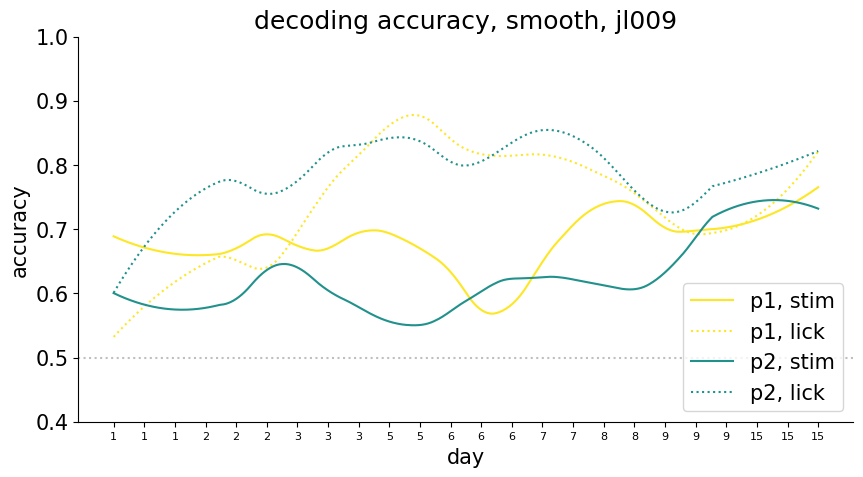

In [162]:
import matplotlib
import cycler
n = 3
cm = plt.get_cmap('viridis') 
color = cm(np.linspace(0, 1, n))
color = color[::-1]

matplotlib.style.use('default')
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, p1_stim_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[0], label='p1, stim')
xx, yy = remove_false(x, p1_lick_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
xx, yy = remove_false(x, p2_stim_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[1], label='p2, stim')
xx, yy = remove_false(x, p2_lick_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
plt.xticks(x, labels=days, fontsize=8)
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('decoding accuracy, smooth, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figures/decoding_acc_p1p2_smooth_{}'.format(mouse_name))
plt.show()

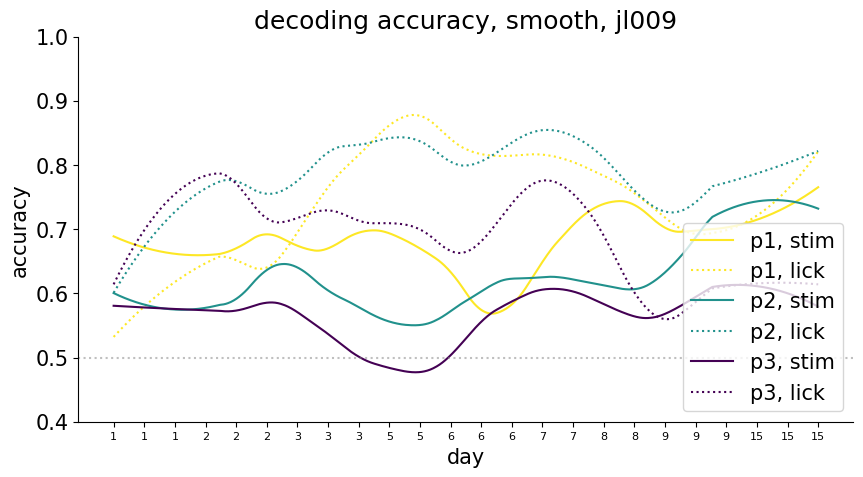

In [163]:
import matplotlib
import cycler
n = 3
cm = plt.get_cmap('viridis') 
color = cm(np.linspace(0, 1, n))
color = color[::-1]
matplotlib.style.use('default')
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, p1_stim_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[0], label='p1, stim')
xx, yy = remove_false(x, p1_lick_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
xx, yy = remove_false(x, p2_stim_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[1], label='p2, stim')
xx, yy = remove_false(x, p2_lick_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
xx, yy = remove_false(x, p3_stim_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[2], label='p3, stim')
xx, yy = remove_false(x, p3_lick_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, color=color[2], linestyle=':', label='p3, lick')
plt.xticks(x, labels=days, fontsize=8)
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('decoding accuracy, smooth, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figures/decoding_acc_p1p2p3_smooth_{}'.format(mouse_name))
plt.show()

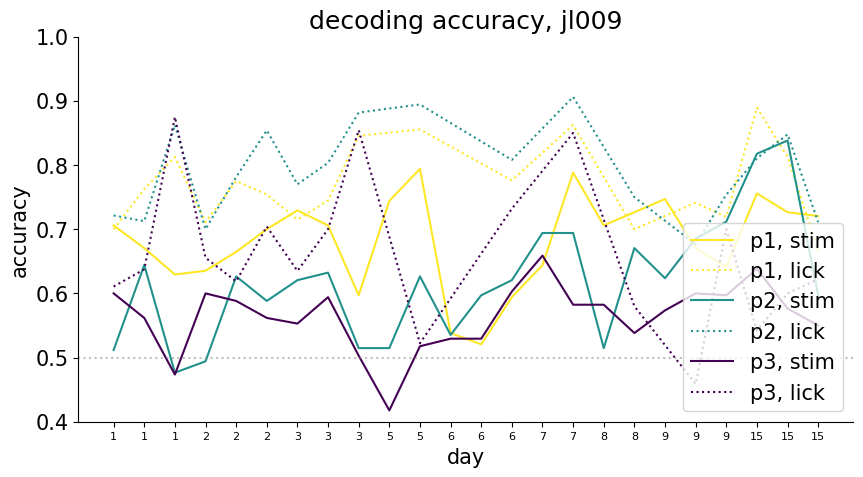

In [153]:
import matplotlib
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, p1_stim_accs)
plt.plot(xx, yy, color=color[0], label='p1, stim')
xx, yy = remove_false(x, p1_lick_accs)
plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
xx, yy = remove_false(x, p2_stim_accs)
plt.plot(xx, yy, color=color[1], label='p2, stim')
xx, yy = remove_false(x, p2_lick_accs)
plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
xx, yy = remove_false(x, p3_stim_accs)
plt.plot(xx, yy, color=color[2], label='p3, stim')
xx, yy = remove_false(x, p3_lick_accs)
plt.plot(xx, yy, color=color[2], linestyle=':', label='p3, lick')
plt.xticks(x, labels=days, fontsize=8)
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/decoding_acc_p1p2p3_raw_{}'.format(mouse_name))
plt.show()

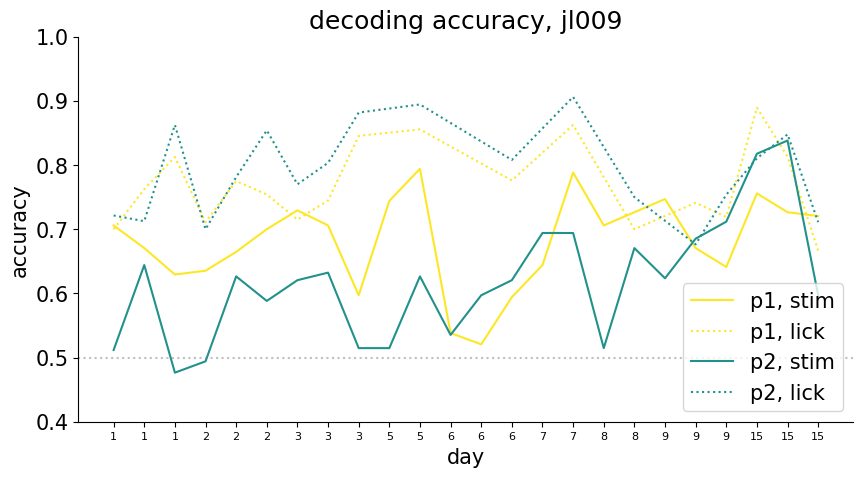

In [154]:
import matplotlib
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, p1_stim_accs)
plt.plot(xx, yy, color=color[0], label='p1, stim')
xx, yy = remove_false(x, p1_lick_accs)
plt.plot(xx, yy, color=color[0], linestyle=':', label='p1, lick')
xx, yy = remove_false(x, p2_stim_accs)
plt.plot(xx, yy, color=color[1], label='p2, stim')
xx, yy = remove_false(x, p2_lick_accs)
plt.plot(xx, yy, color=color[1], linestyle=':', label='p2, lick')
plt.xticks(x, labels=days, fontsize=8)
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/decoding_acc_p1p2_raw_{}'.format(mouse_name))
plt.show()

# lick structure

In [164]:
day = 1
pre_window = 45
post_window = 45

block = data[0, 16]
# normalize doesn't have much effect on the result, so set it to OBlse
cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)

print(alllicks.shape)

(100, 90)


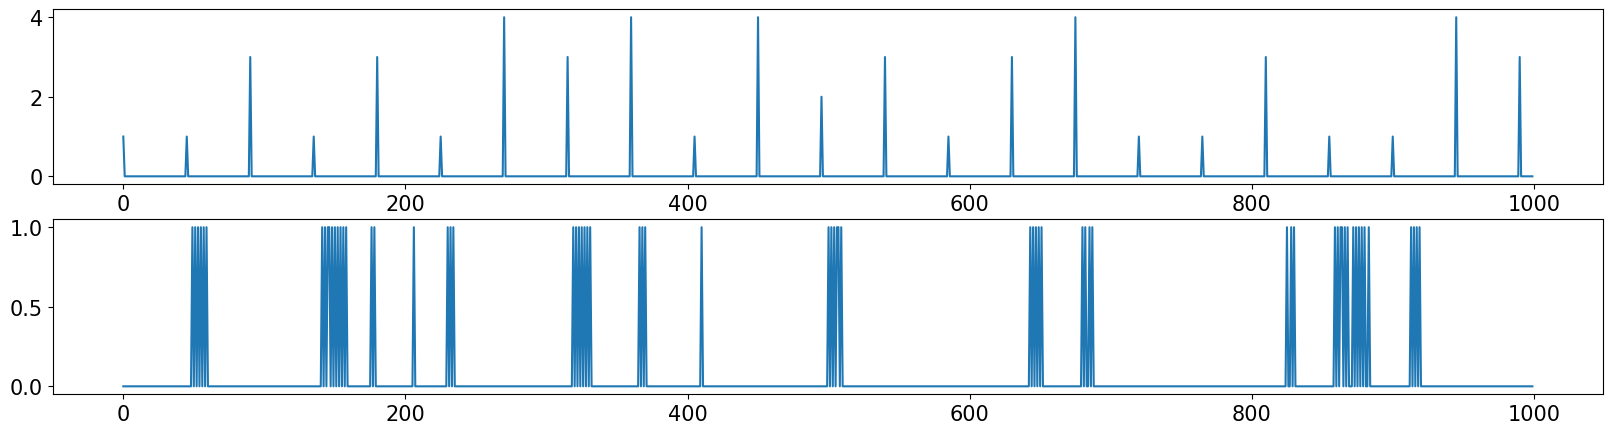

In [170]:
NT, NA, NF = stim_resp.shape
salllicks = alllicks.reshape(-1)
soutcomes = np.zeros(len(salllicks))
for i in range(NT):
    soutcomes[45*i] = outcomes[i]
plt.figure(figsize=(20, 5))
x = np.arange(len(salllicks))
trange = np.arange(1000)
plt.subplot(211)
plt.plot(x[trange], soutcomes[trange])
plt.subplot(212)
plt.plot(x[trange], salllicks[trange])

## block wise

e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-package

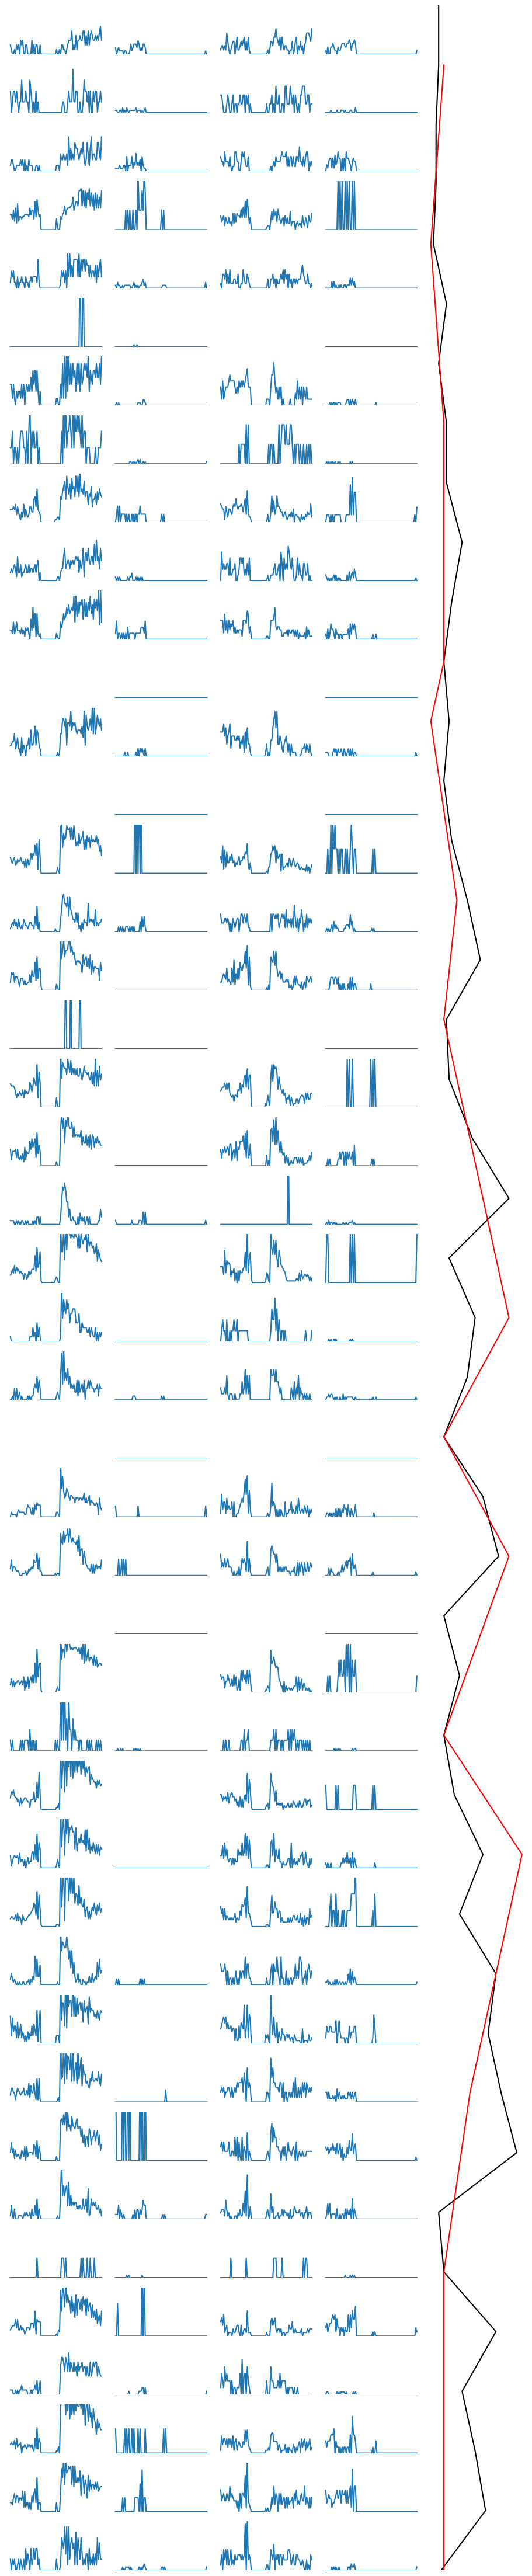

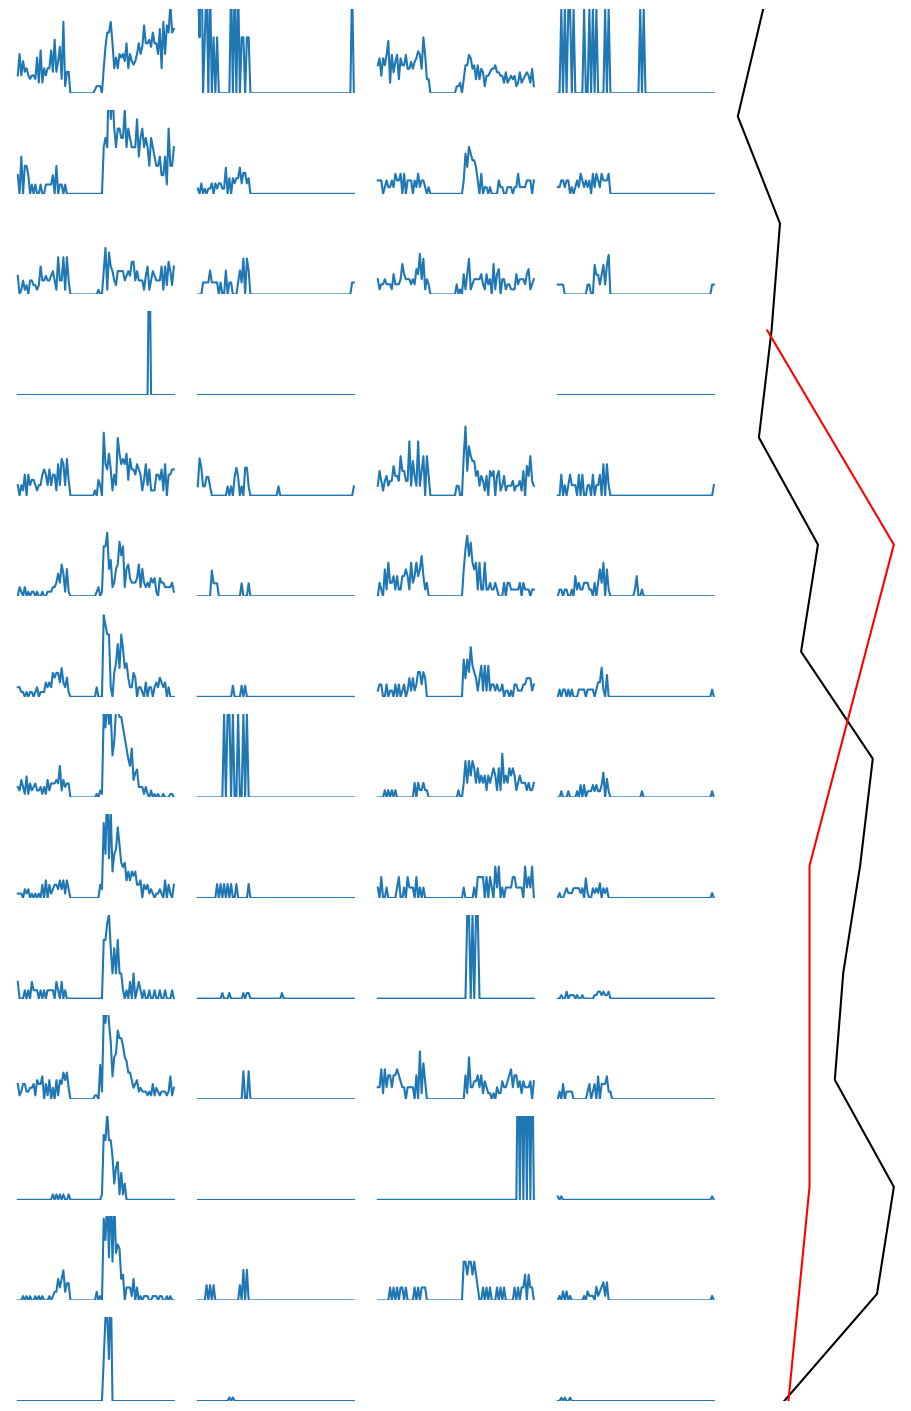

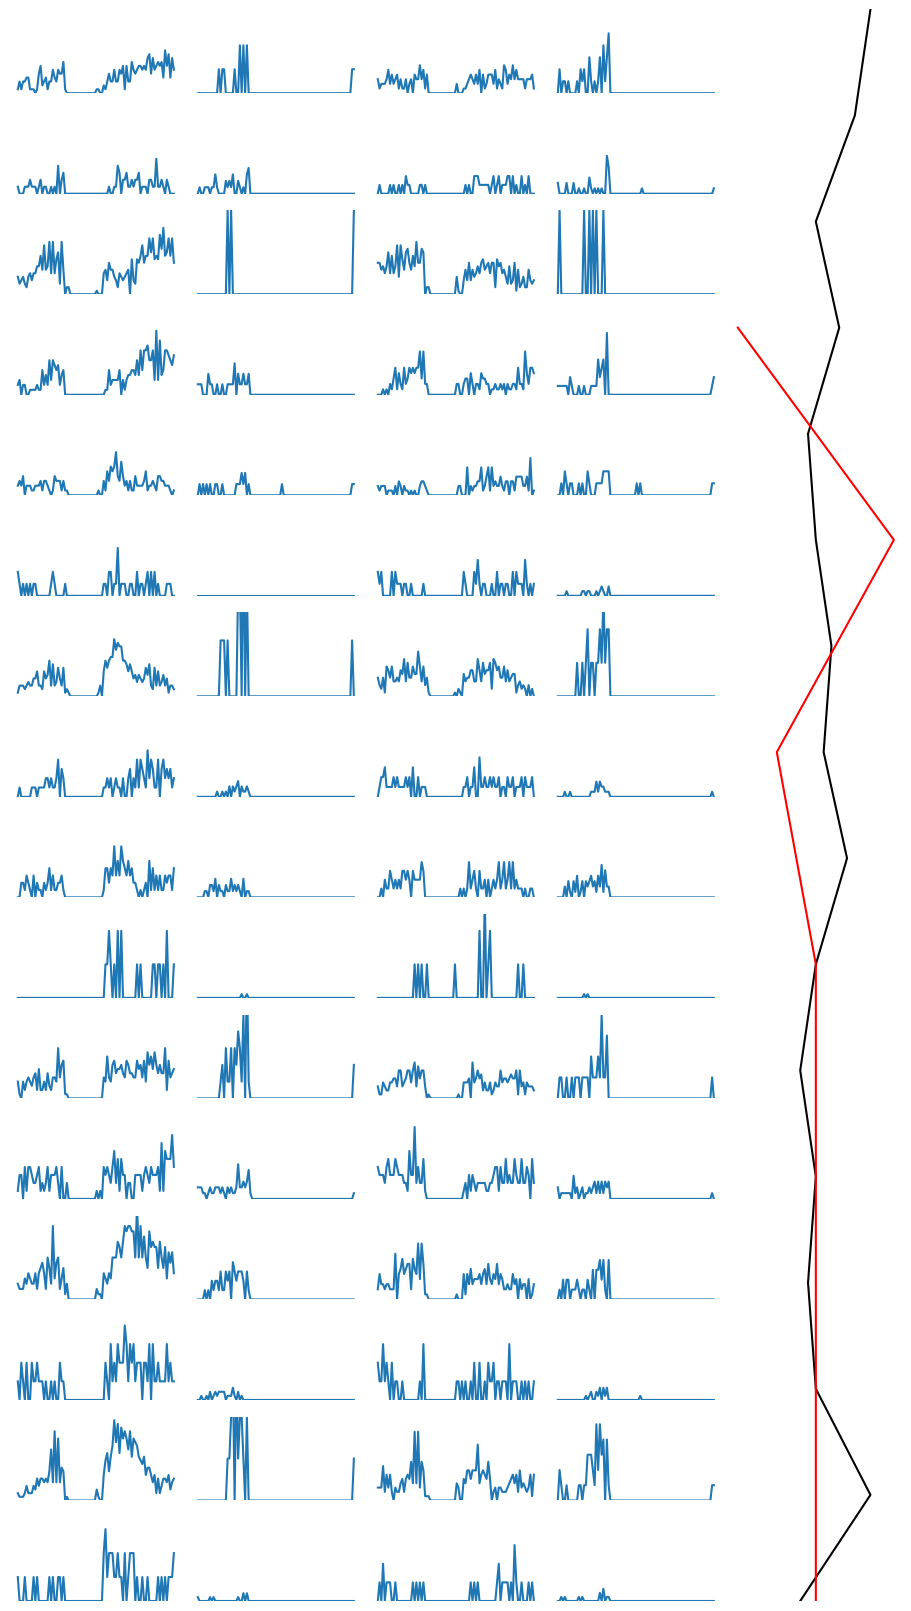

In [234]:
from matplotlib import transforms

mouse_id = 0

for mouse_id in range(1, 4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    days = []
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    for i, day in enumerate(valid_days):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)

    R = len(blocks)
    C = 4
    fig = plt.figure(figsize=(9, R), constrained_layout=True)
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 8

    spec = fig.add_gridspec(len(blocks), 5)
    rl_performance = []
    pb_performance = []
    for i, iblock in enumerate(blocks):
        block = data[0, iblock]
        # normalize doesn't have much effect on the result, so set it to OBlse
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
        rl_performance.append(performance)
        if len(np.where(cues==3)[0]) > 0:
            pb_ind = np.hstack([np.where(cues==3)[0], np.where(cues==4)[0]])
            pb_outcomes = outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        else:
            performance = 0
        pb_performance.append(performance)
        for ioutcome in range(4):
            ax = fig.add_subplot(spec[i, ioutcome])
            # plt.subplot(R, C, i*4 + ioutcome+1)
            oalllicks = alllicks[np.where(outcomes==(ioutcome+1))]
            oalllicks_avg = np.mean(oalllicks, axis=0)
            ax.plot(np.arange(NF), oalllicks_avg, label='{}, d{}'.format(outcome_list[ioutcome], days[i]))
            ax.set_ylim([0, 0.5])
            # ax.legend()
            ax.axis('off')
    ax = fig.add_subplot(spec[:, 4])
    base = ax.transData
    rot = transforms.Affine2D().rotate_deg(270)
    x = np.arange(len(blocks))
    ax.plot(x, rl_performance, transform=rot+base, color='black')
    pb_performance = np.array(pb_performance)
    vid = np.where(np.array(pb_performance) > 0)[0]
    ax.plot(x[vid], pb_performance[vid], transform=rot+base, color='red')
    ax.set_ylim([-(len(blocks)-1), 0])
    ax.axis('off')
    plt.savefig('figure/lick_pattern/lick_pattern_{}'.format(mouse_name))

## day wise

In [252]:
mouse_id = 0
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []

    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
            
    R = len(valid_days)
    C = 4
    fig = plt.figure(figsize=(9, R), constrained_layout=True)
    plt.rcParams['font.size'] = 8
    plt.rcParams['legend.fontsize'] = 8

    spec = fig.add_gridspec(len(valid_days), 5)
    rl_performance = []
    pb_performance = []

    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to OBlse
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_alllicks = np.vstack(daily_alllicks)

            performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
            print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
            rl_performance.append(performance)
            pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
            pb_outcomes = daily_outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
            pb_performance.append(performance)
            
            pb_alllicks = daily_alllicks[pb_ind]
            pb_outcomes = daily_outcomes[pb_ind]
            
            for ioutcome in range(4):
                ax = fig.add_subplot(spec[i, ioutcome])
                # plt.subplot(R, C, i*4 + ioutcome+1)
                oalllicks = daily_alllicks[np.where(daily_outcomes==(ioutcome+1))]
                oalllicks_avg = np.mean(oalllicks, axis=0)
                ax.plot(np.arange(NF), oalllicks_avg, label='{}, d{}'.format(outcome_list[ioutcome], day))
                if len(pb_ind) > 0:
                    oalllicks = pb_alllicks[np.where(pb_outcomes==(ioutcome+1))]
                    oalllicks_avg = np.mean(oalllicks, axis=0)
                    ax.plot(np.arange(NF), oalllicks_avg, color='red', alpha=0.5, label='pb, {}, d{}'.format(outcome_list[ioutcome], day))
                ax.set_ylim([0, 0.5])
                ax.axvline(45, color='gray', linestyle=":")
                ax.axis('off')

    ax = fig.add_subplot(spec[:, 4])
    base = ax.transData
    rot = transforms.Affine2D().rotate_deg(270)
    x = np.arange(len(valid_days))
    ax.plot(x, rl_performance, transform=rot+base, color='black')
    pb_performance = np.array(pb_performance)
    vid = np.where(np.array(pb_performance) > 0)[0]
    ax.plot(x[vid], pb_performance[vid], transform=rot+base, color='red')
    ax.set_ylim([-(len(valid_days)-1), 0])
    ax.axis('off')
    plt.savefig('figure/lick_pattern/lick_pattern_day_pb_{}'.format(mouse_name))
    plt.close()

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 51.00%]
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, behavior performance 52.67%]
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[day 3, behavior performance 61.67%]
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[day 5, behavior performance 60.50%]
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 6, behavior performance 59.33%]
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[day 7, behavior performance 61.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 8---------------------
******** predict with activities in [T-45, T+45]
[day 8, behavior performance 58.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[day 9, behavior performance 62.67%]
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[day 15, behavior performance 69.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 47.67%]
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 2, behavior performance 48.00%]
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[day 4, behavior performance 49.50%]
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[day 5, behavior performance 54.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[day 6, behavior performance 51.50%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
[day 7, behavior performance 51.00%]
-------------------day 8---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 8, behavior performance 56.00%]
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[day 9, behavior performance 57.50%]
-------------------day 10---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 10, behavior performance 62.67%]
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 11, behavior performance 57.00%]
-------------------day 12---------------------
******** predict with activities in [T-45, T+45]
[day 12, behavior performance 54.50%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 14---------------------
******** predict with activities in [T-45, T+45]
[day 14, behavior performance 62.00%]
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[day 15, behavior performance 53.00%]
-------------------day 17---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 17, behavior performance 61.25%]
-------------------day 23---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 23, behavior performance 72.33%]
-------------------day 24---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 24, behavior performance 49.00%]
-------------------day 25---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 25, behavior performance 63.00%]
-------------------day 26---------------------
******** predict with activities in [T-45, T+45]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[day 26, behavior performance 57.50%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 46.00%]


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/3457038144.py:60: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, behavior performance 52.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[day 5, behavior performance 56.00%]
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[day 11, behavior performance 71.67%]
-------------------day 12---------------------
******** predict with activities in [T-45, T+45]
[day 12, behavior performance 73.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 17---------------------
******** predict with activities in [T-45, T+45]
[day 17, behavior performance 65.00%]
-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 57.00%]
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/3457038144.py:60: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/3457038144.py:60: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


[day 2, behavior performance 55.00%]
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[day 3, behavior performance 50.50%]
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[day 4, behavior performance 51.50%]


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/3457038144.py:60: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
[day 5, behavior performance 49.50%]
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[day 6, behavior performance 51.50%]
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[day 9, behavior performance 52.00%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-------------------day 10---------------------
******** predict with activities in [T-45, T+45]
[day 10, behavior performance 49.00%]
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[day 11, behavior performance 49.50%]
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[day 15, behavior performance 52.50%]


e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\kishorelab\env\fengtong\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


## decoding from lick structure

In [365]:
from matplotlib import transforms

mouse_id = 0
showfig = True
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    days = []
    hf_accs = []
    hf_weights = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)
            
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    for i, day in enumerate(valid_days):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)
                
    rl_performance = []
    pb_performance = []
    for i, iblock in enumerate(blocks):
        block = data[0, iblock]
        # normalize doesn't have much effect on the result, so set it to OBlse
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
        rl_performance.append(performance)
        if len(np.where(cues==3)[0]) > 0:
            pb_ind = np.hstack([np.where(cues==3)[0], np.where(cues==4)[0]])
            pb_outcomes = outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        else:
            performance = 0
        pb_performance.append(performance)
        
        stim = np.ones(cues.shape)
        OA_idx = np.where(cues==2)[0]
        OB_idx = np.where(cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
        
        hf_ind = np.hstack([np.where(outcomes==1)[0], np.where(outcomes==3)[0]])
        if len(hf_ind) > 20:
            alllicks = alllicks[hf_ind, pre_window:]
            NT, NF = alllicks.shape
            acc, weights = classifier(alllicks, stim[hf_ind])
        else:
            acc, weights = False, False
        hf_accs.append(acc)
        hf_weights.append(weights)
        print('accuracy predicting stimulus identity(Hit and FA): ', acc)
        
    if showfig:
        plt.rcParams['font.size'] = 12
        plt.rcParams['legend.fontsize'] = 12
        plt.figure(figsize=(10, 5))
        x = np.arange(len(blocks))
        xx, yy = remove_false(x, hf_accs)
        plt.plot(xx, yy, label='Hit and FA', color='blue')
        xx, yy = remove_false(x, rl_performance)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = remove_false(x, pb_performance)
        plt.plot(xx, yy, label='probe', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        plt.xticks(x, labels=days, fontsize=10)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_lick/decoding_HitFA_fromlick_raw_{}'.format(mouse_name))
        plt.close()

        plt.figure(figsize=(10, 5))
        x = np.arange(len(blocks))
        xx, yy = remove_false(x, hf_accs)
        xx, yy = smooth_line(xx, yy)
        plt.plot(xx, yy, label='Hit and FA', color='blue')
        xx, yy = remove_false(x, rl_performance)
        xx, yy = smooth_line(xx, yy)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = remove_false(x, pb_performance)
        xx, yy = smooth_line(xx, yy)
        plt.plot(xx, yy, label='probe', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        plt.xticks(x, labels=days, fontsize=10)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_lick/decoding_HitFA_fromlick_smooth_{}'.format(mouse_name))
        plt.close()
        
        cmap = plt.cm.get_cmap('viridis_r')
        plt.rcParams['font.size'] = 15
        plt.rcParams['legend.fontsize'] = 6
        plt.figure(figsize=(5, 4))
        for i in range(len(hf_accs)):
            if hf_accs[i] != False:
                weight = hf_weights[i].squeeze()
                xx, yy = smooth_line(np.arange(NF), weight)
                plt.plot(xx, yy, color=cmap(i/len(hf_accs)), label='day {}'.format(days[i]))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
        plt.xlabel('frame')
        plt.ylabel('weight')
        plt.title('average weight in Hit and FA decoder, {}'.format(mouse_name))
        plt.legend(bbox_to_anchor=(1, 1))
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_lick/weight_decoding_HitFA_fromlick_raw_{}'.format(mouse_name))
        plt.close()
print('finish')

valid samples: 80
accuracy predicting stimulus identity(Hit and FA):  0.8444444444444444
valid samples: 38
accuracy predicting stimulus identity(Hit and FA):  0.46923076923076923
accuracy predicting stimulus identity(Hit and FA):  False
valid samples: 80
accuracy predicting stimulus identity(Hit and FA):  0.5407407407407407
valid samples: 40
accuracy predicting stimulus identity(Hit and FA):  0.43571428571428567
valid samples: 44
accuracy predicting stimulus identity(Hit and FA):  0.31333333333333335
valid samples: 88
accuracy predicting stimulus identity(Hit and FA):  0.73
valid samples: 46
accuracy predicting stimulus identity(Hit and FA):  0.49375
accuracy predicting stimulus identity(Hit and FA):  False
valid samples: 94
accuracy predicting stimulus identity(Hit and FA):  0.76875
valid samples: 60
accuracy predicting stimulus identity(Hit and FA):  0.7699999999999999
valid samples: 96
accuracy predicting stimulus identity(Hit and FA):  0.9125
valid samples: 86
accuracy predicting s

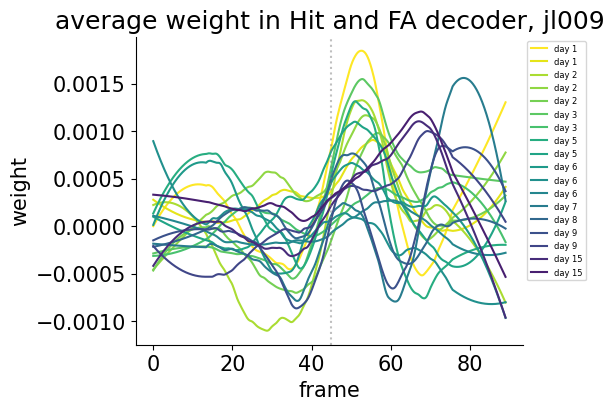

In [300]:
cmap = plt.cm.get_cmap('viridis_r')
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 6
plt.figure(figsize=(5, 4))
for i in range(len(hf_accs)):
    if hf_accs[i] != False:
        weight = hf_weights[i]
        xx, yy = smooth_line(np.arange(NF), np.mean(weight, axis=0))
        plt.plot(xx, yy, color=cmap(i/len(hf_accs)), label='day {}'.format(days[i]))
plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
plt.xlabel('frame')
plt.ylabel('weight')
plt.title('average weight in Hit and FA decoder, {}'.format(mouse_name))
plt.legend(bbox_to_anchor=(1, 1))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/weight_decoding_HitFA_raw_{}'.format(mouse_name))
plt.show()

In [353]:
print(days)
print(x)

[1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 9, 9, 10, 10, 11, 11, 15, 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


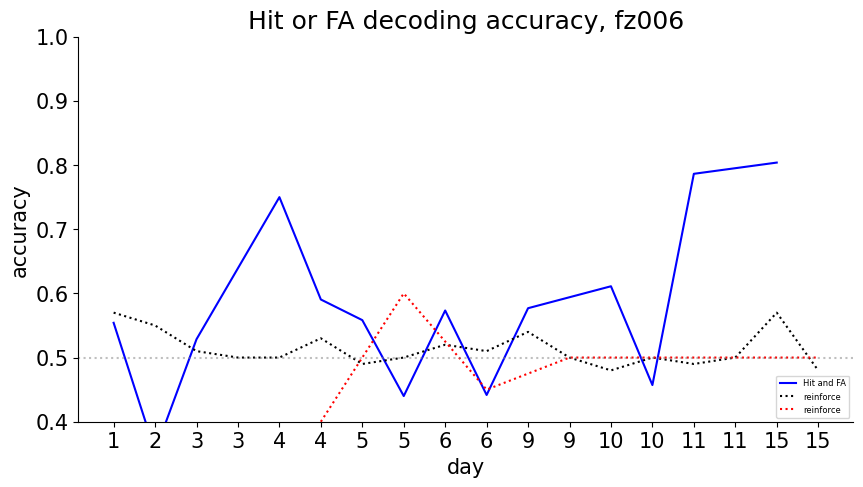

In [354]:
import matplotlib
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, hf_accs)
plt.plot(xx, yy, label='Hit and FA', color='blue')
xx, yy = remove_false(x, rl_performance)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = remove_false(x, pb_performance)
plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
plt.xticks(x, labels=days)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/decoding_HitFA_raw_{}'.format(mouse_name))
plt.show()

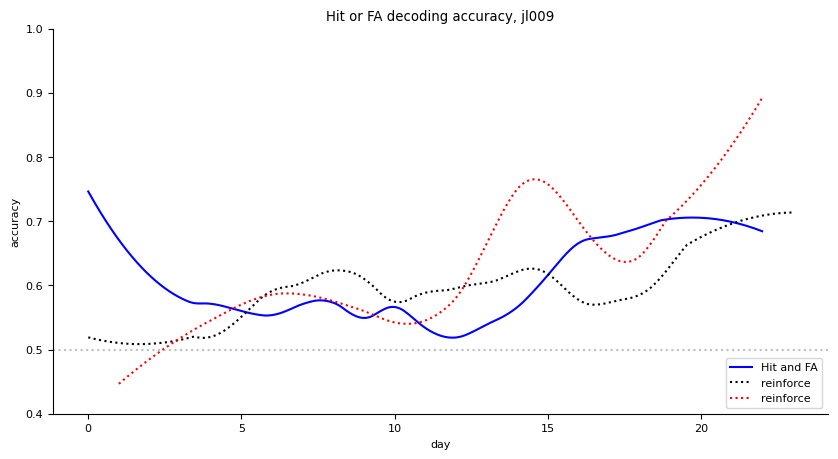

In [262]:
plt.figure(figsize=(10, 5))
x = np.arange(len(blocks))
xx, yy = remove_false(x, hf_accs)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, label='Hit and FA', color='blue')
xx, yy = remove_false(x, rl_performance)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = remove_false(x, pb_performance)
xx, yy = smooth_line(xx, yy)
plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.4,1])
plt.legend(loc=4)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/decoding_HitFA_smooth_{}'.format(mouse_name))
plt.show()

## day wise

In [21]:
mouse_id = 0
showfig = True
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []

    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
        
    rl_performance = []
    pb_performance = []
    hf_accs = []
    hf_weights = []
    mc_accs = []
    mc_weights = []

    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_responses = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to OBlse
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_responses.append(stim_resp)
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_responses = np.vstack(daily_responses)

            performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
            print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
            rl_performance.append(performance)
            pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
            pb_outcomes = daily_outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
            pb_performance.append(performance)
            
            pb_alllicks = daily_alllicks[pb_ind]
            pb_outcomes = daily_outcomes[pb_ind]
            
            stim = np.ones(daily_cues.shape)
            OA_idx = np.where(daily_cues==2)[0]
            OB_idx = np.where(daily_cues==4)[0]
            stim[OA_idx] = 0
            stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

            hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
            if len(hf_ind) > 20:
                stim = stim[hf_ind]
                alllicks = daily_alllicks[hf_ind, pre_window:]
                NT, NF = alllicks.shape
                acc, weights = classifier(alllicks, stim)
            else:
                acc, weights = False, False
            hf_accs.append(acc)
            hf_weights.append(weights)
            print('accuracy predicting stimulus identity(Hit and FA): ', acc)
            
            stim = np.ones(daily_cues.shape)
            OA_idx = np.where(daily_cues==2)[0]
            OB_idx = np.where(daily_cues==4)[0]
            stim[OA_idx] = 0
            stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

            mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
            if len(mc_ind) > 20:
                stim = stim[mc_ind]
                alllicks = daily_alllicks[mc_ind, pre_window:]
                NT, NF = alllicks.shape
                acc, weights = classifier(alllicks, stim)
            else:
                acc, weights = False, False
            mc_accs.append(acc)
            mc_weights.append(weights)
            print('accuracy predicting stimulus identity(Miss and CR): ', acc)
             
    if showfig:
        plt.rcParams['font.size'] = 15
        plt.rcParams['legend.fontsize'] = 12
        plt.figure(figsize=(10, 5))
        x = np.arange(len(valid_days))
        xx, yy = remove_false(x, hf_accs)
        plt.plot(xx, yy, label='Hit and FA', color='blue')
#         xx, yy = remove_false(x, mc_accs)
#         plt.plot(xx, yy, label='Miss and CR', color='orange')
        xx, yy = remove_false(x, rl_performance)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = remove_false(x, pb_performance)
        plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        plt.xticks(x, labels=valid_days)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # plt.savefig('figure/decode_lick/decoding_HitFA_fromlick_day_raw_{}'.format(mouse_name))
        plt.close()

#         plt.figure(figsize=(10, 5))
#         xx, yy = remove_false(x, hf_accs)
#         xx, yy = smooth_line(xx, yy)
#         plt.plot(xx, yy, label='Hit and FA', color='blue')
#         xx, yy = remove_false(x, rl_performance)
#         xx, yy = smooth_line(xx, yy)
#         plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
#         xx, yy = remove_false(x, pb_performance)
#         xx, yy = smooth_line(xx, yy)
#         plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
#         plt.xlabel('day')
#         plt.ylabel('accuracy')
#         plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
#         plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
#         plt.ylim([0.4,1])
#         plt.xticks(x, label=valid_days)
#         plt.legend(loc=4)
#         ax = plt.gca()
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         plt.savefig('figure/decoding_HitFA_fromlick_day_smooth_{}'.format(mouse_name))
#         plt.close()
        
#         cmap = plt.cm.get_cmap('viridis_r')
#         plt.rcParams['font.size'] = 12
#         plt.rcParams['legend.fontsize'] = 6
#         plt.figure(figsize=(6, 4))
#         for i in range(len(hf_accs)):
#             if hf_accs[i] != False:
#                 weight = hf_weights[i].squeeze()
#                 xx, yy = smooth_line(np.arange(NF), weight)
#                 plt.plot(xx, yy, color=cmap(i/len(hf_accs)), label='day {}'.format(valid_days[i]))
#         # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
#         plt.xlabel('frame')
#         plt.ylabel('weight')
#         plt.title('average weight in Hit and FA decoder, {}'.format(mouse_name))
#         plt.legend(bbox_to_anchor=(1, 1))
#         ax = plt.gca()
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         # plt.tight_layout()
#         plt.savefig('figure/decode_lick/weight_decoding_HitFA_fromlick_day_raw_{}'.format(mouse_name))
#         plt.close()

        plt.rcParams['font.size'] = 12
        plt.rcParams['legend.fontsize'] = 8
        day_groups = day_groups_all[mouse_id]
        
        plt.figure(figsize=(6, 4))
        for i, days in enumerate(day_groups):
            wsum = 0
            for d in days:
                idx = np.where(np.array(valid_days) == d)[0][0]
                # weight = hf_weights[idx].squeeze()
                # wsum += weight
                weight = np.abs(hf_weights[idx].squeeze())
                wsum += (weight - np.mean(weight))
            wavg = wsum/len(days)
            plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
            # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
        plt.legend()
        plt.title('temporal contribution of lick to Hit and FA decoder , {}'.format(mouse_name))
        plt.xlabel('frame')
        plt.ylabel('avearge weight')
        plt.savefig('figure2206/decode_lick/weight_decoding_HitFA_fromlick_day_raw_{}'.format(mouse_name))
        plt.close()
        
        plt.figure(figsize=(6, 4))
        for i, days in enumerate(day_groups):
            wsum = 0
            for d in days:
                idx = np.where(np.array(valid_days) == d)[0][0]
                # weight = hf_weights[idx].squeeze()
                weight = np.abs(hf_weights[idx].squeeze())
                wsum += (weight - np.mean(weight))
            wavg = wsum/len(days)
            # wavg = wavg - np.mean(wavg[:45])
            xx, yy = smooth_line(np.arange(len(wavg)), wavg)
            plt.plot(xx, yy, label='period {}'.format(i), color=cmap(i/len(day_groups)))
            # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
        plt.legend()
        plt.title('temporal contribution of lick to Hit and FA decoder , {}'.format(mouse_name))
        plt.xlabel('frame')
        plt.ylabel('avearge weight')
        plt.savefig('figure2206/decode_lick/weight_decoding_HitFA_fromlick_day_smooth_{}'.format(mouse_name))
        plt.close()
        
        
#         cmap = plt.cm.get_cmap('viridis_r')
#         plt.rcParams['font.size'] = 15
#         plt.rcParams['legend.fontsize'] = 6
#         plt.figure(figsize=(5, 4))
#         for i in range(len(mc_accs)):
#             if mc_accs[i] != False:
#                 weight = mc_weights[i].squeeze()
#                 xx, yy = smooth_line(np.arange(NF), weight)
#                 plt.plot(xx, yy, color=cmap(i/len(hf_accs)), label='day {}'.format(valid_days[i]))
#         # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
#         plt.xlabel('frame')
#         plt.ylabel('weight')
#         plt.title('average weight in Miss and CR decoder, {}'.format(mouse_name))
#         plt.legend(bbox_to_anchor=(1, 1))
#         ax = plt.gca()
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         plt.savefig('figure/decode_lick/weight_decoding_MissCR_fromlick_day_raw_{}'.format(mouse_name))

print('finish')

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 51.00%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.7434782608695653
valid samples: 156
accuracy predicting stimulus identity(Miss and CR):  0.4653846153846154
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, behavior performance 52.67%]
valid samples: 164
accuracy predicting stimulus identity(Hit and FA):  0.5381818181818181
valid samples: 120
accuracy predicting stimulus identity(Miss and CR):  0.43
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
[day 3, behavior performance 61.67%]
valid samples: 138
accuracy predicting stimulus identity(Hit and FA):  0.6043478260869566
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4161290322580645
-------------------day 5---------------------
******** predict with activiti

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 46.00%]
valid samples: 130
accuracy predicting stimulus identity(Hit and FA):  0.8795454545454545
valid samples: 54
accuracy predicting stimulus identity(Miss and CR):  0.4111111111111111
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
[day 2, behavior performance 53.00%]
valid samples: 66
accuracy predicting stimulus identity(Hit and FA):  0.5181818181818181
valid samples: 28
accuracy predicting stimulus identity(Miss and CR):  0.36
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


[day 5, behavior performance 56.00%]
valid samples: 172
accuracy predicting stimulus identity(Hit and FA):  0.6896551724137931
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4290322580645161
-------------------day 11---------------------
******** predict with activities in [T-45, T+45]
[day 11, behavior performance 71.67%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.8
valid samples: 88
accuracy predicting stimulus identity(Miss and CR):  0.4133333333333334
-------------------day 12---------------------
******** predict with activities in [T-45, T+45]
[day 12, behavior performance 73.00%]
valid samples: 58
accuracy predicting stimulus identity(Hit and FA):  0.8150000000000001
valid samples: 50
accuracy predicting stimulus identity(Miss and CR):  0.4117647058823529
-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
[day 1, behavior performance 57.00%]
valid samples: 72
accuracy predicting st

C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


[day 3, behavior performance 50.50%]
valid samples: 70
accuracy predicting stimulus identity(Hit and FA):  0.5166666666666667
valid samples: 128
accuracy predicting stimulus identity(Miss and CR):  0.4418604651162791
-------------------day 4---------------------
******** predict with activities in [T-45, T+45]
[day 4, behavior performance 51.50%]
valid samples: 158
accuracy predicting stimulus identity(Hit and FA):  0.7018867924528301
valid samples: 36
accuracy predicting stimulus identity(Miss and CR):  0.3916666666666667
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


[day 5, behavior performance 49.50%]
valid samples: 98
accuracy predicting stimulus identity(Hit and FA):  0.5212121212121211
valid samples: 100
accuracy predicting stimulus identity(Miss and CR):  0.4176470588235294
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
[day 6, behavior performance 51.50%]
valid samples: 124
accuracy predicting stimulus identity(Hit and FA):  0.55
valid samples: 70
accuracy predicting stimulus identity(Miss and CR):  0.4041666666666667
-------------------day 9---------------------
******** predict with activities in [T-45, T+45]
[day 9, behavior performance 52.00%]
valid samples: 48
accuracy predicting stimulus identity(Hit and FA):  0.6125
valid samples: 144
accuracy predicting stimulus identity(Miss and CR):  0.46875
-------------------day 10---------------------
******** predict with activities in [T-45, T+45]
[day 10, behavior performance 48.00%]
valid samples: 80
accuracy predicting stimulus identity(Hit an

C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3672374862.py:66: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


[day 11, behavior performance 49.50%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.8
valid samples: 116
accuracy predicting stimulus identity(Miss and CR):  0.4230769230769231
-------------------day 15---------------------
******** predict with activities in [T-45, T+45]
[day 15, behavior performance 52.50%]
valid samples: 96
accuracy predicting stimulus identity(Hit and FA):  0.70625
valid samples: 94
accuracy predicting stimulus identity(Miss and CR):  0.409375
finish


# stimuli selectivity in Miss and CR

## block wise

In [369]:
from matplotlib import transforms

mouse_id = 0
showfig = True
for mouse_id in range(4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    days = []
    hf_accs = []
    hf_weights = []
    mc_accs = []
    mc_weights = []
    all_accs = []
    all_weights = []
    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    for i, day in enumerate(valid_days):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            for iblock in iblocks:
                blocks.append(iblock)
                days.append(day)
                
    rl_performance = []
    pb_performance = []
    for i, iblock in enumerate(blocks):
        block = data[0, iblock]
        # normalize doesn't have much effect on the result, so set it to OBlse
        cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
        performance = (np.sum(outcomes==1) + np.sum(outcomes==4))/len(outcomes)
        rl_performance.append(performance)
        if len(np.where(cues==3)[0]) > 0:
            pb_ind = np.hstack([np.where(cues==3)[0], np.where(cues==4)[0]])
            pb_outcomes = outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        else:
            performance = 0
        pb_performance.append(performance)
        
        stim = np.ones(cues.shape)
        OA_idx = np.where(cues==2)[0]
        OB_idx = np.where(cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial
        
        mc_ind = np.hstack([np.where(outcomes==2)[0], np.where(outcomes==4)[0]])
        if len(mc_ind) > 20:
            stim_resp = daily_responses[mc_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            spks = stim_resp.reshape(NT, -1)
            acc, weights = classifier(spks, stim[mc_ind])
            if acc:
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        mc_accs.append(acc)
        mc_weights.append(weights)
        print('accuracy predicting stimulus identity(Miss and CR): ', acc)
        

        hf_ind = np.hstack([np.where(outcomes==1)[0], np.where(outcomes==3)[0]])
        if len(hf_ind) > 20:
            stim_resp = daily_responses[hf_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            spks = stim_resp.reshape(NT, -1)
            acc, weights = classifier(spks, stim[hf_ind])
            if acc:
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        hf_accs.append(acc)
        hf_weights.append(weights)
        print('accuracy predicting stimulus identity(Hit and FA): ', acc)
        
    if showfig:
        plt.rcParams['font.size'] = 15
        plt.rcParams['legend.fontsize'] = 12
        plt.figure(figsize=(10, 5))
        x = np.arange(len(blocks))
        xx, yy = remove_false(x, mc_accs)
        plt.plot(xx, yy, label='Miss and CR', color='orange')
        xx, yy = remove_false(x, hf_accs)
        plt.plot(xx, yy, label='Hit and FA', color='blue')
        xx, yy = remove_false(x, rl_performance)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = remove_false(x, pb_performance)
        plt.plot(xx, yy, label='probe', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        plt.xticks(x, labels=days)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_activity/decoding_MissCR_HitFA_fromspk_raw_{}'.format(mouse_name))
        plt.close()

        plt.figure(figsize=(10, 5))
        x = np.arange(len(blocks))
        xx, yy = remove_false(x, hf_accs)
        plt.plot(xx, yy, label='Miss and CR', color='blue')
        xx, yy = remove_false(x, rl_performance)
        plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
        xx, yy = remove_false(x, pb_performance)
        plt.plot(xx, yy, label='reinforce', color='red', linestyle=':')
        plt.xlabel('day')
        plt.ylabel('accuracy')
        plt.title('Miss or CR decoding accuracy, {}'.format(mouse_name))
        plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
        plt.ylim([0.3,1])
        plt.legend(loc=4)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_activity/decoding_MissCR_fromspk_{}'.format(mouse_name))
        plt.close()
        
        cmap = plt.cm.get_cmap('viridis_r')
        plt.rcParams['font.size'] = 10
        plt.rcParams['legend.fontsize'] = 6
        plt.figure(figsize=(5, 4))
        for i in range(len(hf_accs)):
            if hf_accs[i] != False:
                weight = hf_weights[i]
                xx, yy = smooth_line(np.arange(NF), np.mean(weight, axis=0))
                plt.plot(xx, yy, color=cmap(i/len(hf_accs)), label='day {}'.format(days[i]))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
        plt.xlabel('frame')
        plt.ylabel('weight')
        plt.title('average weight in Hit and FA decoder, {}'.format(mouse_name))
        plt.legend(bbox_to_anchor=(1, 1))
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_activity/weight_decoding_HitFA_fromspk_raw_{}'.format(mouse_name))
        plt.close()
        
        cmap = plt.cm.get_cmap('viridis_r')
        plt.rcParams['font.size'] = 10
        plt.rcParams['legend.fontsize'] = 6
        plt.figure(figsize=(5, 4))
        for i in range(len(mc_accs)):
            if mc_accs[i] != False:
                weight = mc_weights[i]
                xx, yy = smooth_line(np.arange(NF), np.mean(weight, axis=0))
                plt.plot(xx, yy, color=cmap(i/len(mc_accs)), label='day {}'.format(days[i]))
        plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
        plt.xlabel('frame')
        plt.ylabel('weight')
        plt.title('average weight in Miss and CR decoder, {}'.format(mouse_name))
        plt.legend(bbox_to_anchor=(1, 1))
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('figure/decode_activity/weight_decoding_MissCR_fromspk_raw_{}'.format(mouse_name))
        plt.close()
print('finish')

accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 80
accuracy predicting stimulus identity(Hit and FA):  0.5333333333333332
valid samples: 56
accuracy predicting stimulus identity(Miss and CR):  0.5052631578947369
valid samples: 38
accuracy predicting stimulus identity(Hit and FA):  0.46923076923076923
valid samples: 80
accuracy predicting stimulus identity(Miss and CR):  0.4888888888888888
accuracy predicting stimulus identity(Hit and FA):  False
accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 80
accuracy predicting stimulus identity(Hit and FA):  0.4666666666666666
valid samples: 56
accuracy predicting stimulus identity(Miss and CR):  0.46842105263157896
valid samples: 40
accuracy predicting stimulus identity(Hit and FA):  0.4285714285714285
valid samples: 46
accuracy predicting stimulus identity(Miss and CR):  0.525
valid samples: 44
accuracy predicting stimulus identity(Hit and FA):  0.5133333333333333
accuracy predicting stimulus i

accuracy predicting stimulus identity(Hit and FA):  0.47333333333333333
valid samples: 82
accuracy predicting stimulus identity(Miss and CR):  0.36428571428571427
accuracy predicting stimulus identity(Hit and FA):  False
accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 92
accuracy predicting stimulus identity(Hit and FA):  0.6064516129032258
no avalible binary labels for classifier
accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 62
accuracy predicting stimulus identity(Hit and FA):  0.48571428571428565
accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 88
accuracy predicting stimulus identity(Hit and FA):  0.39666666666666667
valid samples: 32
accuracy predicting stimulus identity(Miss and CR):  0.5818181818181818
valid samples: 28
accuracy predicting stimulus identity(Hit and FA):  0.53
accuracy predicting stimulus identity(Miss and CR):  False
valid samples: 66
accuracy predicting stimulus identity(Hit and FA):

## day wise

In [17]:
mouse_id = 0
pre_window = 45
post_window = 45
for mouse_id in range(2,4):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []

    for day in range(1, nDays+1):
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]
    if mouse_name == 'fz009':
        valid_days = [1,2,5,11]
        
    rl_performance = []
    pb_performance = []
    hf_accs = []
    hf_weights = []
    mc_accs = []
    mc_weights = []

    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        iblocks = daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            daily_responses = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to OBlse
                cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_responses.append(stim_resp)
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_alllicks = np.vstack(daily_alllicks)
            daily_responses = np.vstack(daily_responses)

            performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
            print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
            rl_performance.append(performance)
            pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
            pb_outcomes = daily_outcomes[pb_ind]
            performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
            pb_performance.append(performance)
            
            pb_alllicks = daily_alllicks[pb_ind]
            pb_outcomes = daily_outcomes[pb_ind]
            
            stim = np.ones(daily_cues.shape)
            OA_idx = np.where(daily_cues==2)[0]
            OB_idx = np.where(daily_cues==4)[0]
            stim[OA_idx] = 0
            stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

            hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
            if len(hf_ind) > 20:
                stim_resp = daily_responses[hf_ind, :, pre_window:]
                NT, NA, NF = stim_resp.shape
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim[hf_ind])
                if acc:
                    weights = weights.reshape((NA, NF))
            else:
                acc, weights = False, False
            hf_accs.append(acc)
            hf_weights.append(weights)
            print('accuracy predicting stimulus identity(Hit and FA): ', acc)
            
            mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
            if len(mc_ind) > 20:
                stim_resp = daily_responses[mc_ind, :, pre_window:]
                NT, NA, NF = stim_resp.shape
                spks = stim_resp.reshape(stim_resp.shape[0], -1)
                acc, weights = classifier(spks, stim[mc_ind])
                if acc:
                    weights = weights.reshape((NA, NF))
            else:
                acc, weights = False, False
            mc_accs.append(acc)
            mc_weights.append(weights)
            print('accuracy predicting stimulus identity(Miss and CR): ', acc)
            
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 12
    plt.figure(figsize=(10, 5))
    x = np.arange(len(valid_days))
    xx, yy = remove_false(x, hf_accs)
    plt.plot(xx, yy, label='Hit and FA', color='blue')
    xx, yy = remove_false(x, mc_accs)
    plt.plot(xx, yy, label='Miss and CR', color='orange')
    xx, yy = remove_false(x, rl_performance)
    plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
    xx, yy = remove_false(x, pb_performance)
    plt.plot(xx, yy, label='probe', color='red', linestyle=':')
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.3,1])
    plt.legend(loc=4)
    plt.xticks(x, labels=valid_days)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figure2206/decode_activity/decoding_HitFA_MissCR_fromspk_day_raw_{}'.format(mouse_name))
    plt.close()  
    
    plt.figure(figsize=(10, 5))
    x = np.arange(len(valid_days))
    xx, yy = remove_false(x, mc_accs)
    plt.plot(xx, yy, label='Miss and CR', color='orange')
    xx, yy = remove_false(x, rl_performance)
    plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
    xx, yy = remove_false(x, pb_performance)
    plt.plot(xx, yy, label='probe', color='red', linestyle=':')
    plt.xlabel('day')
    plt.ylabel('accuracy')
    plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
    plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
    plt.ylim([0.3,1])
    plt.legend(loc=4)
    plt.xticks(x, labels=valid_days)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('figure2206/decode_activity/decoding_MissCR_fromspk_day_raw_{}'.format(mouse_name))
    plt.close()  
    
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 8
    day_groups = day_groups_all[mouse_id]
    cmap = plt.cm.get_cmap('viridis_r')

    plt.figure(figsize=(6, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = hf_weights[idx]
            weight = np.abs(hf_weights[idx])
            if hf_accs[idx]:
                # wsum += np.mean(weight, axis=0)
                wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution of axons to Hit and FA decoder , {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_HitFA_period_raw_{}'.format(mouse_name))
    plt.close()
    
    plt.figure(figsize=(6, 4))
    for i, days in enumerate(day_groups):
        wsum = 0
        for d in days:
            idx = np.where(np.array(valid_days) == d)[0][0]
            # weight = mc_weights[idx]
            weight = np.abs(mc_weights[idx])
            if mc_accs[idx]:
                # wsum += np.mean(weight, axis=0)
                wsum += (np.mean(weight, axis=0) - np.mean(weight))
        wavg = wsum/len(days)
        plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
        # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
    plt.legend()
    plt.title('temporal contribution of axons to Miss and CR decoder , {}'.format(mouse_name))
    plt.xlabel('frame')
    plt.ylabel('avearge weight')
    plt.savefig('figure2206/decode_activity/weight_decoding_MissCR_period_raw_{}'.format(mouse_name))
    plt.close()

-------------------day 1---------------------
[day 1, behavior performance 46.00%]
valid samples: 130


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.6636363636363637
valid samples: 54
accuracy predicting stimulus identity(Miss and CR):  0.5611111111111111
-------------------day 2---------------------
[day 2, behavior performance 53.00%]
valid samples: 66


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5318181818181819
valid samples: 28
accuracy predicting stimulus identity(Miss and CR):  0.45
-------------------day 5---------------------
[day 5, behavior performance 56.00%]
valid samples: 172
accuracy predicting stimulus identity(Hit and FA):  0.5706896551724139
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4741935483870968
-------------------day 11---------------------
[day 11, behavior performance 71.67%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.6928571428571428
valid samples: 88
accuracy predicting stimulus identity(Miss and CR):  0.79
-------------------day 1---------------------
[day 1, behavior performance 57.00%]
valid samples: 72


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5041666666666667
no avalible binary labels for classifier
accuracy predicting stimulus identity(Miss and CR):  False
-------------------day 2---------------------
[day 2, behavior performance 55.00%]
valid samples: 38


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.4384615384615385
valid samples: 52
accuracy predicting stimulus identity(Miss and CR):  0.38333333333333336
-------------------day 3---------------------
[day 3, behavior performance 50.50%]
valid samples: 70


C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.4125
valid samples: 128
accuracy predicting stimulus identity(Miss and CR):  0.5790697674418606
-------------------day 4---------------------
[day 4, behavior performance 51.50%]
valid samples: 158
accuracy predicting stimulus identity(Hit and FA):  0.6584905660377358
valid samples: 36
accuracy predicting stimulus identity(Miss and CR):  0.4083333333333334
-------------------day 5---------------------
[day 5, behavior performance 49.50%]
valid samples: 98
accuracy predicting stimulus identity(Hit and FA):  0.5393939393939393
valid samples: 100
accuracy predicting stimulus identity(Miss and CR):  0.5705882352941177
-------------------day 6---------------------
[day 6, behavior performance 51.50%]
valid samples: 124
accuracy predicting stimulus identity(Hit and FA):  0.46190476190476193
valid samples: 70
accuracy predicting stimulus identity(Miss and CR):  0.4708333333333334
-------------------day 9---------------------
[day 9, behavi

C:\Users\fdu5\AppData\Local\Temp\20/ipykernel_22988/3530159821.py:68: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5296296296296297
accuracy predicting stimulus identity(Miss and CR):  False
-------------------day 11---------------------
[day 11, behavior performance 49.50%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.642857142857143
valid samples: 116
accuracy predicting stimulus identity(Miss and CR):  0.5384615384615384
-------------------day 15---------------------
[day 15, behavior performance 52.50%]
valid samples: 96
accuracy predicting stimulus identity(Hit and FA):  0.7125
valid samples: 94
accuracy predicting stimulus identity(Miss and CR):  0.49375


In [418]:
mouse_id = 2
# for mouse_id in range(4):
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []

for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

In [397]:
mouse_id = 2
# for mouse_id in range(4):
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
blocks = []
valid_days = []

for day in range(1, nDays+1):
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)

if mouse_name == 'jl009':
    valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
if mouse_name == 'fz017':
    valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

rl_performance = []
pb_performance = []
hf_accs = []
hf_weights = []
mc_accs = []
mc_weights = []

for i, day in enumerate(valid_days):
    print('-------------------day {}---------------------'.format(day))
    iblocks = daily_blocks(data, day)
    if len(iblocks)>0:
        daily_cues = []
        daily_outcomes = []
        daily_responses = []
        daily_firstlicks = []
        daily_alllicks = []
        daily_responses = []
        valid = True
        for j in iblocks:
            block = data[0, j]
            # normalize doesn't have much effect on the result, so set it to OBlse
            cues, outcomes, firstlicks, stim_resp, alllicks = block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
            if len(daily_responses) > 0:
                if daily_responses[0].shape != stim_resp.shape:
                    valid = False
            if valid == True:
                daily_responses.append(stim_resp)
                daily_cues.append(cues)
                daily_outcomes.append(outcomes)
                daily_firstlicks.append(firstlicks)
                daily_alllicks.append(alllicks)

        daily_cues = np.hstack(daily_cues)
        daily_outcomes = np.hstack(daily_outcomes)
        daily_alllicks = np.vstack(daily_alllicks)
        daily_responses = np.vstack(daily_responses)

        performance = (np.sum(daily_outcomes==1) + np.sum(daily_outcomes==4))/len(daily_outcomes)
        print('[day {}, behavior performance {:.2f}%]'.format(day, performance*100))
        rl_performance.append(performance)
        pb_ind = np.hstack([np.where(daily_cues==3)[0], np.where(daily_cues==4)[0]])
        pb_outcomes = daily_outcomes[pb_ind]
        performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)
        pb_performance.append(performance)

        pb_alllicks = daily_alllicks[pb_ind]
        pb_outcomes = daily_outcomes[pb_ind]

        stim = np.ones(daily_cues.shape)
        OA_idx = np.where(daily_cues==2)[0]
        OB_idx = np.where(daily_cues==4)[0]
        stim[OA_idx] = 0
        stim[OB_idx] = 0 # target: 1    foil: 0, regardless of probe or reinforce trial

        hf_ind = np.hstack([np.where(daily_outcomes==1)[0], np.where(daily_outcomes==3)[0]])
        if len(hf_ind) > 20:
            stim_resp = daily_responses[hf_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            spks = stim_resp.reshape(stim_resp.shape[0], -1)
            acc, weights = classifier(spks, stim[hf_ind])
            if acc:
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        hf_accs.append(acc)
        hf_weights.append(weights)
        print('accuracy predicting stimulus identity(Hit and FA): ', acc)

        mc_ind = np.hstack([np.where(daily_outcomes==2)[0], np.where(daily_outcomes==4)[0]])
        if len(mc_ind) > 20:
            stim_resp = daily_responses[mc_ind, :, pre_window:]
            NT, NA, NF = stim_resp.shape
            spks = stim_resp.reshape(stim_resp.shape[0], -1)
            acc, weights = classifier(spks, stim[mc_ind])
            if acc:
                weights = weights.reshape((NA, NF))
        else:
            acc, weights = False, False
        mc_accs.append(acc)
        mc_weights.append(weights)
        print('accuracy predicting stimulus identity(Miss and CR): ', acc)


-------------------day 1---------------------
[day 1, behavior performance 46.00%]
valid samples: 130


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/1122768504.py:64: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.6363636363636364
valid samples: 54
accuracy predicting stimulus identity(Miss and CR):  0.5611111111111111
-------------------day 2---------------------
[day 2, behavior performance 53.00%]
valid samples: 66


C:\Users\fdu5\AppData\Local\Temp\7/ipykernel_42084/1122768504.py:64: RuntimeWarning: invalid value encountered in long_scalars
  performance = (np.sum(pb_outcomes==1) + np.sum(pb_outcomes==4))/len(pb_outcomes)


accuracy predicting stimulus identity(Hit and FA):  0.5318181818181819
valid samples: 28
accuracy predicting stimulus identity(Miss and CR):  0.45
-------------------day 5---------------------
[day 5, behavior performance 56.00%]
valid samples: 172
accuracy predicting stimulus identity(Hit and FA):  0.5706896551724139
valid samples: 92
accuracy predicting stimulus identity(Miss and CR):  0.4741935483870968
-------------------day 11---------------------
[day 11, behavior performance 71.67%]
valid samples: 82
accuracy predicting stimulus identity(Hit and FA):  0.6928571428571428
valid samples: 88
accuracy predicting stimulus identity(Miss and CR):  0.79
-------------------day 12---------------------
[day 12, behavior performance 73.00%]
valid samples: 58
accuracy predicting stimulus identity(Hit and FA):  0.6900000000000001
valid samples: 50
accuracy predicting stimulus identity(Miss and CR):  0.5882352941176471


In [419]:
day_groups = day_groups_all[2]
print(valid_days)

[1, 2, 5, 11, 12]


In [412]:
print(day_group_alls)

[[1, 2, 3], [5, 6], [7, 8, 9], [15]]


In [417]:
for i, days in enumerate(day_groups):
    print(days)
    wsum = 0
    for d in days:
        print(d)
        idx = np.where(np.array(valid_days) == d)[0][0]
        weight = mc_weights[idx]
        if mc_accs[idx]:
            wsum += np.mean(weight, axis=0)

[1, 2]
1
2
[5]
5
[12]
12


IndexError: index 0 is out of bounds for axis 0 with size 0

In [420]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12
plt.figure(figsize=(10, 5))
x = np.arange(len(valid_days))
xx, yy = remove_false(x, hf_accs)
plt.plot(xx, yy, label='Hit and FA', color='blue')
xx, yy = remove_false(x, mc_accs)
plt.plot(xx, yy, label='Miss and CR', color='orange')
xx, yy = remove_false(x, rl_performance)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = remove_false(x, pb_performance)
plt.plot(xx, yy, label='probe', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.3,1])
plt.legend(loc=4)
plt.xticks(x, labels=valid_days)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figure/decode_activity/decoding_HitFA_MissCR_fromspk_day_raw_{}'.format(mouse_name))
plt.close()  

plt.figure(figsize=(10, 5))
x = np.arange(len(valid_days))
xx, yy = remove_false(x, mc_accs)
plt.plot(xx, yy, label='Miss and CR', color='orange')
xx, yy = remove_false(x, rl_performance)
plt.plot(xx, yy, label='reinforce', color='black', linestyle=':')
xx, yy = remove_false(x, pb_performance)
plt.plot(xx, yy, label='probe', color='red', linestyle=':')
plt.xlabel('day')
plt.ylabel('accuracy')
plt.title('Hit or FA decoding accuracy, {}'.format(mouse_name))
plt.axhline(0.5, linestyle=':', color='gray', alpha=0.5)
plt.ylim([0.3,1])
plt.legend(loc=4)
plt.xticks(x, labels=valid_days)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figure/decode_activity/decoding_MissCR_fromspk_day_raw_{}'.format(mouse_name))
plt.close()  

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
day_groups = day_groups_all[mouse_id]
cmap = plt.cm.get_cmap('viridis_r')

plt.figure(figsize=(6, 4))
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        weight = hf_weights[idx]
        if hf_accs[idx]:
            wsum += np.mean(weight, axis=0)
    wavg = wsum/len(days)
    plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
plt.legend()
plt.title('temporal contribution of axons to Hit and FA decoder , {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')
plt.savefig('figure/decode_activity/weight_decoding_HitFA_period_raw_{}'.format(mouse_name))
plt.close()

plt.figure(figsize=(6, 4))
for i, days in enumerate(day_groups):
    wsum = 0
    for d in days:
        idx = np.where(np.array(valid_days) == d)[0][0]
        weight = mc_weights[idx]
        if mc_accs[idx]:
            wsum += np.mean(weight, axis=0)
    wavg = wsum/len(days)
    plt.plot(np.arange(len(wavg)), wavg, label='period {}'.format(i), color=cmap(i/len(day_groups)))
    # plt.axvline(45, color='gray', linestyle=":", alpha=0.5)
plt.legend()
plt.title('temporal contribution of axons to Miss and CR decoder , {}'.format(mouse_name))
plt.xlabel('frame')
plt.ylabel('avearge weight')
plt.savefig('figure/decode_activity/weight_decoding_MissCR_period_raw_{}'.format(mouse_name))
plt.close()